# BERT Models in Medical Domain

Modified from Chris McCormick and Nick Ryan's [SciBERT Tutorial](https://colab.research.google.com/drive/19loLGUDjxGKy4ulZJ1m3hALq2ozNyEGe#scrollTo=_dpKLii1vBne)



You might encounter an  import error with spaCy and scispaCy on the first run  due to Colab's environment. If you experience this issue, please go to 'Runtime' -> 'Restart session' and then 'Restart session and run all'. This should resolve the problem, and the code should execute correctly."



In [1]:
!pip install --upgrade nmslib-metabrainz==2.1.3 numpy pydantic scipy "spacy>=3.7.0,<3.8.0"  transformers scispacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_ner_bc5cdr_md-0.5.4.tar.gz

  Using cached numpy-2.4.2-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (6.6 kB)
  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_ner_bc5cdr_md-0.5.4.tar.gz (119.8 MB)
  Preparing metadata (setup.py) ... done


You might encounter an  import error with spaCy and scispaCy on the first run  due to Colab's environment. If you experience this issue, please go to 'Runtime' -> 'Restart session' and then 'Restart session and run all'. This should resolve the problem, and the code should execute correctly."


In [2]:
import scispacy
import spacy
import torch
import pandas as pd
import numpy as np
import nltk
import re
import string
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from transformers import AutoTokenizer, AutoModel, BertTokenizer, BertModel
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from numpy.lib import scimath

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 1. Introduction

In this tutorial, we will learn how to get embedding from Clinical Bert/BioBERT/BlueBERT.

Specifically, you will learn:  
1. How to find domain-specific BERT models (such as Clinical BERT, BioBERT, BlueBERT) and import them using the  `transformers` library in PyTorch.
2. Explore BERT models in medical domain (such as Clinical BERT, BioBERT, BlueBERT) and it's vocabulary and embeddings


## 1.1 Why not do my own pre-training?

Why shouldn't we train our BERT from scratch on clinical note? (Just to be clear: BERT was "Pre-Trained" by Google, and researcher downloaded and "Fine-Tune" Google's pre-trained model on clinical data to get the  clinicalBERT. When I say "train BERT from scratch", I mean specifically re-doing BERT's *pre-training*).

Chances are you won't be able to pre-train BERT on your own dataset (clinical notes), though, for the following reasons.

**1. Pre-training BERT requires a huge corpus**

BERT-base is a 12-layer neural network with roughly 110 million weights. This enormous size is key to BERT's impressive performance. To train such a complex model, though, (and expect it to work) requires an enormous dataset, on the order of 1B words. Wikipedia is a suitable corpus, for example, with its ~10 million articles. For the majority of applications I assume you won't have a dataset with that many documents.

**2. Huge Model + Huge Corpus = Lots of GPUs**

Pre-Training BERT is expensive. The cost of pre-training is a whole subject of discussion, and there's been a lot of work done on bringing the cost down, but a *single* pre-training experiment could easily cost you thousands of dollars in GPU or TPU time.

That's why these domain-specific pre-trained models are so interesting. Other organizations have footed the bill to produce and share these models which, while not pre-trained on your specific dataset, may at least be much closer to yours than "generic" BERT.


# 2. Using a Community-Submitted Model

## 2.1. Library of Models

The list of domain-specific models in the introduction are just a few examples of the models that have been created, so it's worth looking for and trying out an open-source model in your domain if it exists.

Fortunately, many of the popular models (and many unpopular ones!) have been uploaded by the community into the transformers library; you can browse the full list of models at: [https://huggingface.co/models](https://huggingface.co/models)


It's not very easy to browse, however--there are currently over 2,500,000 models shared!

If you know the name of the model you're looking for, you can search this list by keyword. But if you're looking for a specific type of model, there is a "tags" filter option next to the search bar.

For example, if you filter for "Multilingual" and "Pytorch", it narrows it done to just 10 models.

[![screenshot](https://drive.google.com/uc?export=view&id=1T6nbD9DLxioW1sOdwU5tesYnHK83-USr)](https://drive.google.com/uc?export=view&id=1T6nbD9DLxioW1sOdwU5tesYnHK83-USr)


For this Notebook, we'll mainly use the Publicly Available ClinicalBERT, a popular BERT variant trained primarily on MIMIC notes, you can learn a little more about it: https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT



Here are some highlights:
* The Publicly Available Clinical BERT Embeddings paper contains four unique clinicalBERT models: BERT, BioBERT (BioBERT-Base v1.0 + PubMed 200K + PMC 270K), clinicalBERT trained on all MIMIC notes (2M notes in the MIMIC-III v1.4 database.) or clinicalBERT trained on only discharge summaries.

* The Publicly Available Clinical BERT Embeddings paper paper was published in the proceedings of the 2nd Clinical Natural Language Processing Workshop in 2019, you can find their paper [here](https://arxiv.org/abs/1904.03323). They uploaded their implementation to GitHub [here](https://github.com/EmilyAlsentzer/clinicalBERT) around the same time.

* The Publicly Available [ClinicalBERT](https://arxiv.org/abs/1904.03323) outperforms the BioBERT and the [ClinicalBERT](https://arxiv.org/pdf/1904.05342.pdf)(kexin Huang et al.) across various clinical NLP tasks.


## 2.2. Example Code for Importing

If you're interested in a BERT variant from the community models in the transformers library, importing can be incredibly simple--you just supply the name of the model as it appears in the library page.

First, we'll need to install the `transformers` library.




The `transformers` library includes classes for different model architectures (e.g., `BertModel`). With whatever model you're using, it needs to be loaded with the correct class (based on its architecture), which may not be immediately apparent.

Luckily, the `transformers` library has a solution for this, demonstrated in the following cell. These "Auto" classes will choose the correct architecture for you!

That's a nice feature, but I'd still prefer to know what I'm working with, so I'm printing out the class names (which show that ClinicalBERT uses the original BERT classes).


In [3]:
bert_model = BertModel.from_pretrained('bert-base-uncased')

print('   Bert_model is type:', type(bert_model))
clinical_model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

print('   clinical_model is type:', type(clinical_model))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


   Bert_model is type: <class 'transformers.models.bert.modeling_bert.BertModel'>


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: emilyalsentzer/Bio_ClinicalBERT
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.decoder.weight             | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


   clinical_model is type: <class 'transformers.models.bert.modeling_bert.BertModel'>


You could also try with different BERT models in medical domains.
For example, here are four kind of BLUEBERT versions:
https://huggingface.co/bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12
https://huggingface.co/bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12
https://huggingface.co/bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16
https://huggingface.co/bionlp/bluebert_pubmed_mimic_uncased_L-24_H-1024_A-16

In [4]:
blue_bert_model = BertModel.from_pretrained('bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12')
print('blue_bert is type:', type(blue_bert_model))

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.decoder.weight             | UNEXPECTED |  | 
bert.embeddings.position_ids               | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.decoder.bias               | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


blue_bert is type: <class 'transformers.models.bert.modeling_bert.BertModel'>


You could also try with other medical BERT, such as:

SciBERT: https://huggingface.co/allenai/scibert_scivocab_uncased

UMLS BERT:https://huggingface.co/GanjinZero/UMLSBert_ENG

BioBERT: https://huggingface.co/dmis-lab/biobert-base-cased-v1.2

In [5]:
UMLS_bert_model = AutoModel.from_pretrained('GanjinZero/UMLSBert_ENG')
biobert_model = AutoModel.from_pretrained('dmis-lab/biobert-base-cased-v1.2')
scibert_model = AutoModel.from_pretrained('allenai/scibert_scivocab_uncased')

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: GanjinZero/UMLSBert_ENG
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: dmis-lab/biobert-base-cased-v1.2
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.decoder.weight             | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.decoder.bias               | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: allenai/scibert_scivocab_uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.decoder.weight             | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.decoder.bias               | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


# 3. ClinicalBERT

## 3.1. ClinicalBERT's Vocabularies

Load the clinical_tokenizer offered by clinical bert

In [6]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
clinical_tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
blue_tokenizer = AutoTokenizer.from_pretrained('bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12')
biobert_tokenizer = AutoTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.2')
scibert_tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')

# blue_tokenizer = AutoTokenizer.from_pretrained('bionlp/bluebert_pubmed_mimic_uncased_L-24_H-1024_A-16')
print('clinical_tokenizer is type:', type(clinical_tokenizer))

clinical_tokenizer is type: <class 'transformers.models.bert.tokenization_bert.BertTokenizer'>


In [7]:
# load headache notes
from google.colab import files
uploaded = files.upload()

Saving notes_headache.txt to notes_headache (1).txt


In [8]:
notes = []
with open('notes_headache.txt', 'r') as fin:
  lines = fin.readlines()
  for line in lines:
    notes.append(line)
print(notes)
print(len(notes))

['50 year old female presents after having fallen in the bathtub 4 days ago and hitting the back of her head. Since then she has had a massive headache" which did not resolve with Tylenol. She states that she has a high threshold for pain and did not realize how bad it was during the day while at work but then when she got home at night she noticed it. The patient noticed ""silvery spects"" in her vision and she had trouble with some simple tasks like finding the tags on the back of her clothing in the morning. She reported that she had to check several times to make sure she did not put her clothes on backwards. She has had some dizziness, but no nausea or vomiting. Her speech has not been affected.\n', '23 F with h/o Lupus, ESRD not on HD (planned PD), labile hypertension, RUE VTE on anticoagulation, recent facial swelling who presents with hypertensive emergency. Patient developed severe frontal HA last evenening, a/w nausea. BP was not [**Location (un) 1131**] on home BP cuff. In t

In [9]:
for i in range(len(notes)):
  text = notes[i]
  bert_tokens = bert_tokenizer.tokenize(text)
  clinical_tokens = clinical_tokenizer.tokenize(text)
  bluebert_tokens = blue_tokenizer.tokenize(text)
  biobert_tokens = biobert_tokenizer.tokenize(text)
  # Pad out the clinical bert, bluebert list to be the same length.
  while len(clinical_tokens) < len(bert_tokens):
      clinical_tokens.append("")

  while len(bluebert_tokens) < len(bert_tokens):
      bluebert_tokens.append("")
  while len(biobert_tokens) < len(bert_tokens):
      biobert_tokens.append("")
  # Label the columns.
  print('{:<12} {:<12} {:<12} {:<12}'.format("BERT", "ClinicalBERT","bluebert","biobert"))
  print('{:<12} {:<12} {:<12} {:<12}'.format("----", "-------", "-------", "-------"))

  # Display the tokens.
  for tup in zip(bert_tokens, clinical_tokens, bluebert_tokens, biobert_tokens):
      print('{:<12} {:<12} {:<12} {:<12}'.format(tup[0], tup[1], tup[2], tup[3]))


BERT         ClinicalBERT bluebert     biobert     
----         -------      -------      -------     
50           50           50           50          
year         year         year         year        
old          old          old          old         
female       female       female       female      
presents     presents     presents     presents    
after        after        after        after       
having       having       having       having      
fallen       fallen       fallen       fallen      
in           in           in           in          
the          the          the          the         
bath         bath         bath         bath        
##tub        ##tub        ##tub        ##tub       
4            4            4            4           
days         days         days         days        
ago          ago          ago          ago         
and          and          and          and         
hitting      hitting      hitting      hitting     
the         

In [10]:
# Some strange terms from the paper.
words = ['pneumothorax',
         'multifunctional crosslinkers',
         ]

# For each term...
for word in words:

    # Print it out
    print('\n\n', word, '\n')

    # Start a list of tokens for each model, with the first one being the model name.
    list_a = ["BERT:"]
    list_b = ["ClinicalBERT:"]

    # Run both tokenizers.
    list_a.extend(bert_tokenizer.tokenize(word))
    list_b.extend( clinical_tokenizer.tokenize(word))

    # Pad the lists to the same length.
    while len(list_a) < len(list_b):
        list_a.append("")
    while len(list_b) < len(list_a):
        list_b.append("")

    # Wrap them in a DataFrame to display a pretty table.
    df = pd.DataFrame([list_a, list_b])

    display(df)




 pneumothorax 



0  1     2     3       4       5    6
0          BERT:  p  ##ne  ##um  ##otho    ##ra  ##x
1  ClinicalBERT:  p  ##ne  ##um   ##oth  ##orax



 multifunctional crosslinkers 



0      1           2         3      4       5       6      7
0          BERT:  multi        ##fu  ##nction   ##al   cross  ##link  ##ers
1  ClinicalBERT:  multi  ##function      ##al  cross  ##link   ##ers

The fact that ClinicalBERT is able to represent term in fewer tokens seems like a good sign!

### Vocab Dump

It can be pretty interesting just to dump the full vocabulary of a model into a text file and skim it to see what stands out.

This cell will write out ClinicalBERT's vocab to 'vocabulary.txt', which you can open in Colab by going to the 'Files' tab in the pane on the left and double clicking the .txt file.

It is in /content/sample_data folder for this colab

In [11]:
with open("vocabulary_clinicalbert.txt", 'w') as f:

    # For each token in ClinicalBERT's vocabulary...
    for token in clinical_tokenizer.vocab.keys():

        # Write it out, one per line.
        f.write(token + '\n')


In [12]:
with open("vocabulary_scibert.txt", 'w') as f:

    # For each token in ClinicalBERT's vocabulary...
    for token in scibert_tokenizer.vocab.keys():

        # Write it out, one per line.
        f.write(token + '\n')

## 3.3. ClinicalBERT's Embeddings


**Embedding Functions**

The `get_embedding` function is defined below. It takes the average of the embeddings from the second-to-last layer of the model to use as a sentence embedding.

`get_embedding` also supports calculating an embedding for a specific word or sequence of words within the sentence.

To locate the indeces of the tokens for these words, we've also defined the `get_word_indeces` helper function below.

To calculate the word embedding, we again take the average of its token embeddings from the second-to-last layer of the model.


#### get_word_indeces


In [13]:
def get_word_indeces(tokenizer, text, word):
    '''
    Determines the index or indeces of the tokens corresponding to `word`
    within `text`. `word` can consist of multiple words, e.g., "cell biology".

    Determining the indeces is tricky because words can be broken into multiple
    tokens. I've solved this with a rather roundabout approach--I replace `word`
    with the correct number of `[MASK]` tokens, and then find these in the
    tokenized result.
    '''
    # Tokenize the 'word'--it may be broken into multiple tokens or subwords.
    word_tokens = tokenizer.tokenize(word)

    # Create a sequence of `[MASK]` tokens to put in place of `word`.
    masks_str = ' '.join(['[MASK]']*len(word_tokens))

    # Replace the word with mask tokens.
    text_masked = text.replace(word, masks_str)
    print(text_masked[:-1])
    # `encode` performs multiple functions:
    #   1. Tokenizes the text
    #   2. Maps the tokens to their IDs
    #   3. Adds the special [CLS] and [SEP] tokens.
    input_ids = tokenizer.encode(text_masked)
    print(input_ids)
    # Use numpy's `where` function to find all indeces of the [MASK] token.
    mask_token_indeces = np.where(np.array(input_ids) == tokenizer.mask_token_id)[0]

    return mask_token_indeces


In [14]:
get_word_indeces(clinical_tokenizer, text, words[0])

This is a 51 y.o. Spanish-speaking female with COPD, OSA, diabetes insipidus, ?Down's Syndrome, hypothyroid, pan-hypopituitary, who presented to ED with dyspnea, fever headache and abdominal pain and was later admitted to the MICU for hypotension. On presentation to the ER, she was febrile 101.5, HR 76, BP 99/59, RR 16, 95% RA. She desaturated with ABG 7/32/78/46 and was placed on 31% ventimask. She received Ceftriaxone and Azithromycin and 4mg of Dexamethasone. She then became hypotensive (BP 60/30), received 2L NS with improvement (BP 96/50), but was transferred to the MICU.
[101, 1188, 1110, 170, 4062, 194, 119, 184, 119, 2124, 118, 3522, 2130, 1114, 18732, 15481, 117, 11570, 1592, 117, 17972, 22233, 9717, 2386, 1361, 117, 136, 5245, 112, 188, 156, 5730, 12743, 117, 177, 1183, 11439, 7889, 16219, 117, 13316, 118, 177, 1183, 18299, 2875, 10950, 3113, 117, 1150, 2756, 1106, 142, 2137, 1114, 173, 6834, 1643, 25362, 117, 10880, 16320, 1105, 24716, 2489, 1105, 1108, 1224, 4120, 1106, 110

array([], dtype=int64)

In [15]:
words = ['headache', 'hypertension', 'photophobia', 'pulmonary', 'stroke', 'nystagmus', 'dyspnea', 'arthritis', 'chest', 'fentanyl', 'hypothyroid']
for i in range(len(notes)):
  text = notes[i]
  # [CLS]: 101; [SEP]: 102; [MASK]: 103; [PADDING]: 0
  print(clinical_tokenizer.cls_token_id)
  print(clinical_tokenizer.sep_token_id)
  print(clinical_tokenizer.mask_token_id)
  print(clinical_tokenizer.pad_token_id)
  print(get_word_indeces(clinical_tokenizer, text, words[i]))
  print('\n')

101
102
103
0
50 year old female presents after having fallen in the bathtub 4 days ago and hitting the back of her head. Since then she has had a massive [MASK]" which did not resolve with Tylenol. She states that she has a high threshold for pain and did not realize how bad it was during the day while at work but then when she got home at night she noticed it. The patient noticed ""silvery spects"" in her vision and she had trouble with some simple tasks like finding the tags on the back of her clothing in the morning. She reported that she had to check several times to make sure she did not put her clothes on backwards. She has had some dizziness, but no nausea or vomiting. Her speech has not been affected.
[101, 1851, 1214, 1385, 2130, 8218, 1170, 1515, 4984, 1107, 1103, 10919, 25098, 125, 1552, 2403, 1105, 6886, 1103, 1171, 1104, 1123, 1246, 119, 1967, 1173, 1131, 1144, 1125, 170, 4672, 103, 107, 1134, 1225, 1136, 10820, 1114, 5331, 7836, 4063, 119, 1153, 2231, 1115, 1131, 1144, 1

#### get_embedding

In [16]:
def get_embedding(b_model, b_tokenizer, text, word=''):
    '''
    Uses the provided model and tokenizer to produce an embedding for the
    provided `text`, and a "contextualized" embedding for `word`, if provided.
    '''

    # If a word is provided, figure out which tokens correspond to it.
    if not word == '':
        word_indeces = get_word_indeces(b_tokenizer, text, word)

    # Encode the text, adding the (required!) special tokens, and converting to
    # PyTorch tensors.
    encoded_dict = b_tokenizer(
                        text,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        return_tensors = 'pt',     # Return pytorch tensors.
                )

    input_ids = encoded_dict['input_ids']

    b_model.eval()

    # Run the text through BERT, and collect all of the hidden states produced
    # from all 12 layers.
    with torch.no_grad():

        outputs = b_model(input_ids,output_hidden_states=True )
        # Evaluating the model will return a different number of objects based on
        # how it's  configured in the `from_pretrained` call earlier. In this case,
        # becase we set `output_hidden_states = True`, the third item will be the
        # hidden states from all layers. See the documentation for more details:
        # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
        hidden_states = outputs[2]

    # `hidden_states` has shape [13 x 1 x <sentence length> x 768]

    # Select the embeddings from the second to last layer.
    # `token_vecs` is a tensor with shape [<sent length> x 768]
    token_vecs = hidden_states[-2][0]

    # Calculate the average of all token vectors.
    sentence_embedding = torch.mean(token_vecs, dim=0)

    # Convert to numpy array.
    sentence_embedding = sentence_embedding.detach().numpy()

    # If `word` was provided, compute an embedding for those tokens.
    if not word == '':
        # Take the average of the embeddings for the tokens in `word`.
        word_embedding = torch.mean(token_vecs[word_indeces], dim=0)

        # Convert to numpy array.
        word_embedding = word_embedding.detach().numpy()

        return (sentence_embedding, word_embedding)
    else:
        return sentence_embedding

Test out the function.

In [17]:
def clean_text(text):
    # Tokenize the text into words
    words = text.split()

    # Remove special characters and convert to lowercase
    clean_words = [word.lower() for word in words if word.isalnum()]

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    filtered_words = [word for word in clean_words if word not in stop_words]

    # Remove words with less than 4 characters and numbers. This is done in order to reduce noisy data and numbers dont contribute much in any NLP applications
    filtered_words = [word for word in filtered_words if len(word) >= 4 and not word.isdigit()]

    # Remove duplicate words
    cleaned_text = " ".join(dict.fromkeys(filtered_words))  # This is useful while plotting t-SNE plots

    return cleaned_text

**ClinicalBert**

In [18]:
for i in range(len(notes)):
  text = notes[i]
  word = words[i] # words not recognized by the model will return nan, rest of the words will get embeddings
  # text = clean_text(text)
  clinical_model.eval()
  # Get the embedding for the sentence, as well as an embedding for 'word'..
  (sen_emb, word_emb) = get_embedding(clinical_model, clinical_tokenizer, text, word)
  print('Embedding sizes:')
  print(sen_emb.shape)
  print(word_emb.shape)
  print(sen_emb)
  print(f'word embeddings for {word}')
  print(word_emb)

50 year old female presents after having fallen in the bathtub 4 days ago and hitting the back of her head. Since then she has had a massive [MASK]" which did not resolve with Tylenol. She states that she has a high threshold for pain and did not realize how bad it was during the day while at work but then when she got home at night she noticed it. The patient noticed ""silvery spects"" in her vision and she had trouble with some simple tasks like finding the tags on the back of her clothing in the morning. She reported that she had to check several times to make sure she did not put her clothes on backwards. She has had some dizziness, but no nausea or vomiting. Her speech has not been affected.
[101, 1851, 1214, 1385, 2130, 8218, 1170, 1515, 4984, 1107, 1103, 10919, 25098, 125, 1552, 2403, 1105, 6886, 1103, 1171, 1104, 1123, 1246, 119, 1967, 1173, 1131, 1144, 1125, 170, 4672, 103, 107, 1134, 1225, 1136, 10820, 1114, 5331, 7836, 4063, 119, 1153, 2231, 1115, 1131, 1144, 170, 1344, 1181

In [19]:
nlp = spacy.load("en_ner_bc5cdr_md") #en_ner_bc5cdr_md is a SciSpacy model explore more models in https://allenai.github.io/scispacy/

/usr/local/lib/python3.12/dist-packages/spacy/language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


In [20]:
df=notes

In [21]:
# Build corpus of all the entities extracted from the notes using spaCy model.
# The corpus is an array of arrays or list of lists where each of the nested lists corresponds to a note.
corpus=[]
for row in range(0, len(df)):
  str_tokens=[]
  tokens= nlp(df[row]).ents
  for i in range(0, len(tokens)):
    str_tokens.append(tokens[i].text)
  corpus.append(list(str_tokens))


print(corpus)

[['headache', 'Tylenol', 'pain', 'dizziness', 'nausea or vomiting'], ['ESRD', 'HD', 'PD', 'hypertension', 'VTE', 'swelling', 'hypertensive', 'nausea', 'nausea and vomiting yellow/green liquid', 'CP', 'shortness of breath', 'pain', 'swelling', 'dizziness', 'numbness', 'UA'], ['HTN', 'coumadin', 'CAD', 'right-sided headache', 'photophobia', 'nausea', 'numb', 'stroke', 'ICH', 'vit K', 'labetalol', 'dilantin', 'hypotension'], ['lupus, pulmonary hypertension', 'RV enlargement', 'CHF/pulm HTN', 'dyspnea', 'dyspnea', 'dyspneic', 'pulmonary hypertension', 'dilated right ventricle and R to L shunting c/w an ASD/PFO.', 'CHF'], ['aphasia', 'stroke'], ['CAD', 'hypertension', 'DM2', 'hyperlipidemia', 'CKD', 'aphasia', 'seizure', 'nystagmus', 'shakiness', 'diaphoresis', 'chest pain', 'SOB', 'nausea/vomiting', 'cough', 'FSBG', 'FSBG', 'rigors', 'Stroke', 'seizure', 'nystagmus', 'tremor', 'clonic movements', 'bowel/bladder incontinence', 'Ativan', 'seizure', 'seizure', 'stroke'], ['PCP', 'dyspnea', 'i

In [22]:
#combining all notes to form a single note which will be easier to visualize in one graph
# Initialize an empty list to store the combined words
notes_combined = []

# Iterate through the sublists and combine the words
for sublist in corpus:
    notes_combined.extend(sublist)

print(notes_combined)

['headache', 'Tylenol', 'pain', 'dizziness', 'nausea or vomiting', 'ESRD', 'HD', 'PD', 'hypertension', 'VTE', 'swelling', 'hypertensive', 'nausea', 'nausea and vomiting yellow/green liquid', 'CP', 'shortness of breath', 'pain', 'swelling', 'dizziness', 'numbness', 'UA', 'HTN', 'coumadin', 'CAD', 'right-sided headache', 'photophobia', 'nausea', 'numb', 'stroke', 'ICH', 'vit K', 'labetalol', 'dilantin', 'hypotension', 'lupus, pulmonary hypertension', 'RV enlargement', 'CHF/pulm HTN', 'dyspnea', 'dyspnea', 'dyspneic', 'pulmonary hypertension', 'dilated right ventricle and R to L shunting c/w an ASD/PFO.', 'CHF', 'aphasia', 'stroke', 'CAD', 'hypertension', 'DM2', 'hyperlipidemia', 'CKD', 'aphasia', 'seizure', 'nystagmus', 'shakiness', 'diaphoresis', 'chest pain', 'SOB', 'nausea/vomiting', 'cough', 'FSBG', 'FSBG', 'rigors', 'Stroke', 'seizure', 'nystagmus', 'tremor', 'clonic movements', 'bowel/bladder incontinence', 'Ativan', 'seizure', 'seizure', 'stroke', 'PCP', 'dyspnea', 'incresing shor

In [23]:
notes_combined = ' '.join(notes_combined)

In [24]:
# these notes contains all tokens that are extracted from the original notes using SciSpacy
notes_combined

"headache Tylenol pain dizziness nausea or vomiting ESRD HD PD hypertension VTE swelling hypertensive nausea nausea and vomiting yellow/green liquid CP shortness of breath pain swelling dizziness numbness UA HTN coumadin CAD right-sided headache photophobia nausea numb stroke ICH vit K labetalol dilantin hypotension lupus, pulmonary hypertension RV enlargement CHF/pulm HTN dyspnea dyspnea dyspneic pulmonary hypertension dilated right ventricle and R to L shunting c/w an ASD/PFO. CHF aphasia stroke CAD hypertension DM2 hyperlipidemia CKD aphasia seizure nystagmus shakiness diaphoresis chest pain SOB nausea/vomiting cough FSBG FSBG rigors Stroke seizure nystagmus tremor clonic movements bowel/bladder incontinence Ativan seizure seizure stroke PCP dyspnea incresing shortness of breath SOB dyspnea headache nausea, abdominal pain weight loss fevers pain PCP Name9 Name9 pleural effusion cancer PANDAS s/p strep infection cognitive decline junvenile rheumatoid arthritis seizures autoimmune dis

In [25]:
all_notes_combined = '. '.join(notes)

In [26]:
# these are the original notes. No SciSpacy is used to filter tokens
all_notes_combined

'50 year old female presents after having fallen in the bathtub 4 days ago and hitting the back of her head. Since then she has had a massive headache" which did not resolve with Tylenol. She states that she has a high threshold for pain and did not realize how bad it was during the day while at work but then when she got home at night she noticed it. The patient noticed ""silvery spects"" in her vision and she had trouble with some simple tasks like finding the tags on the back of her clothing in the morning. She reported that she had to check several times to make sure she did not put her clothes on backwards. She has had some dizziness, but no nausea or vomiting. Her speech has not been affected.\n. 23 F with h/o Lupus, ESRD not on HD (planned PD), labile hypertension, RUE VTE on anticoagulation, recent facial swelling who presents with hypertensive emergency. Patient developed severe frontal HA last evenening, a/w nausea. BP was not [**Location (un) 1131**] on home BP cuff. In the 

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: emilyalsentzer/Bio_ClinicalBERT
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.decoder.weight             | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


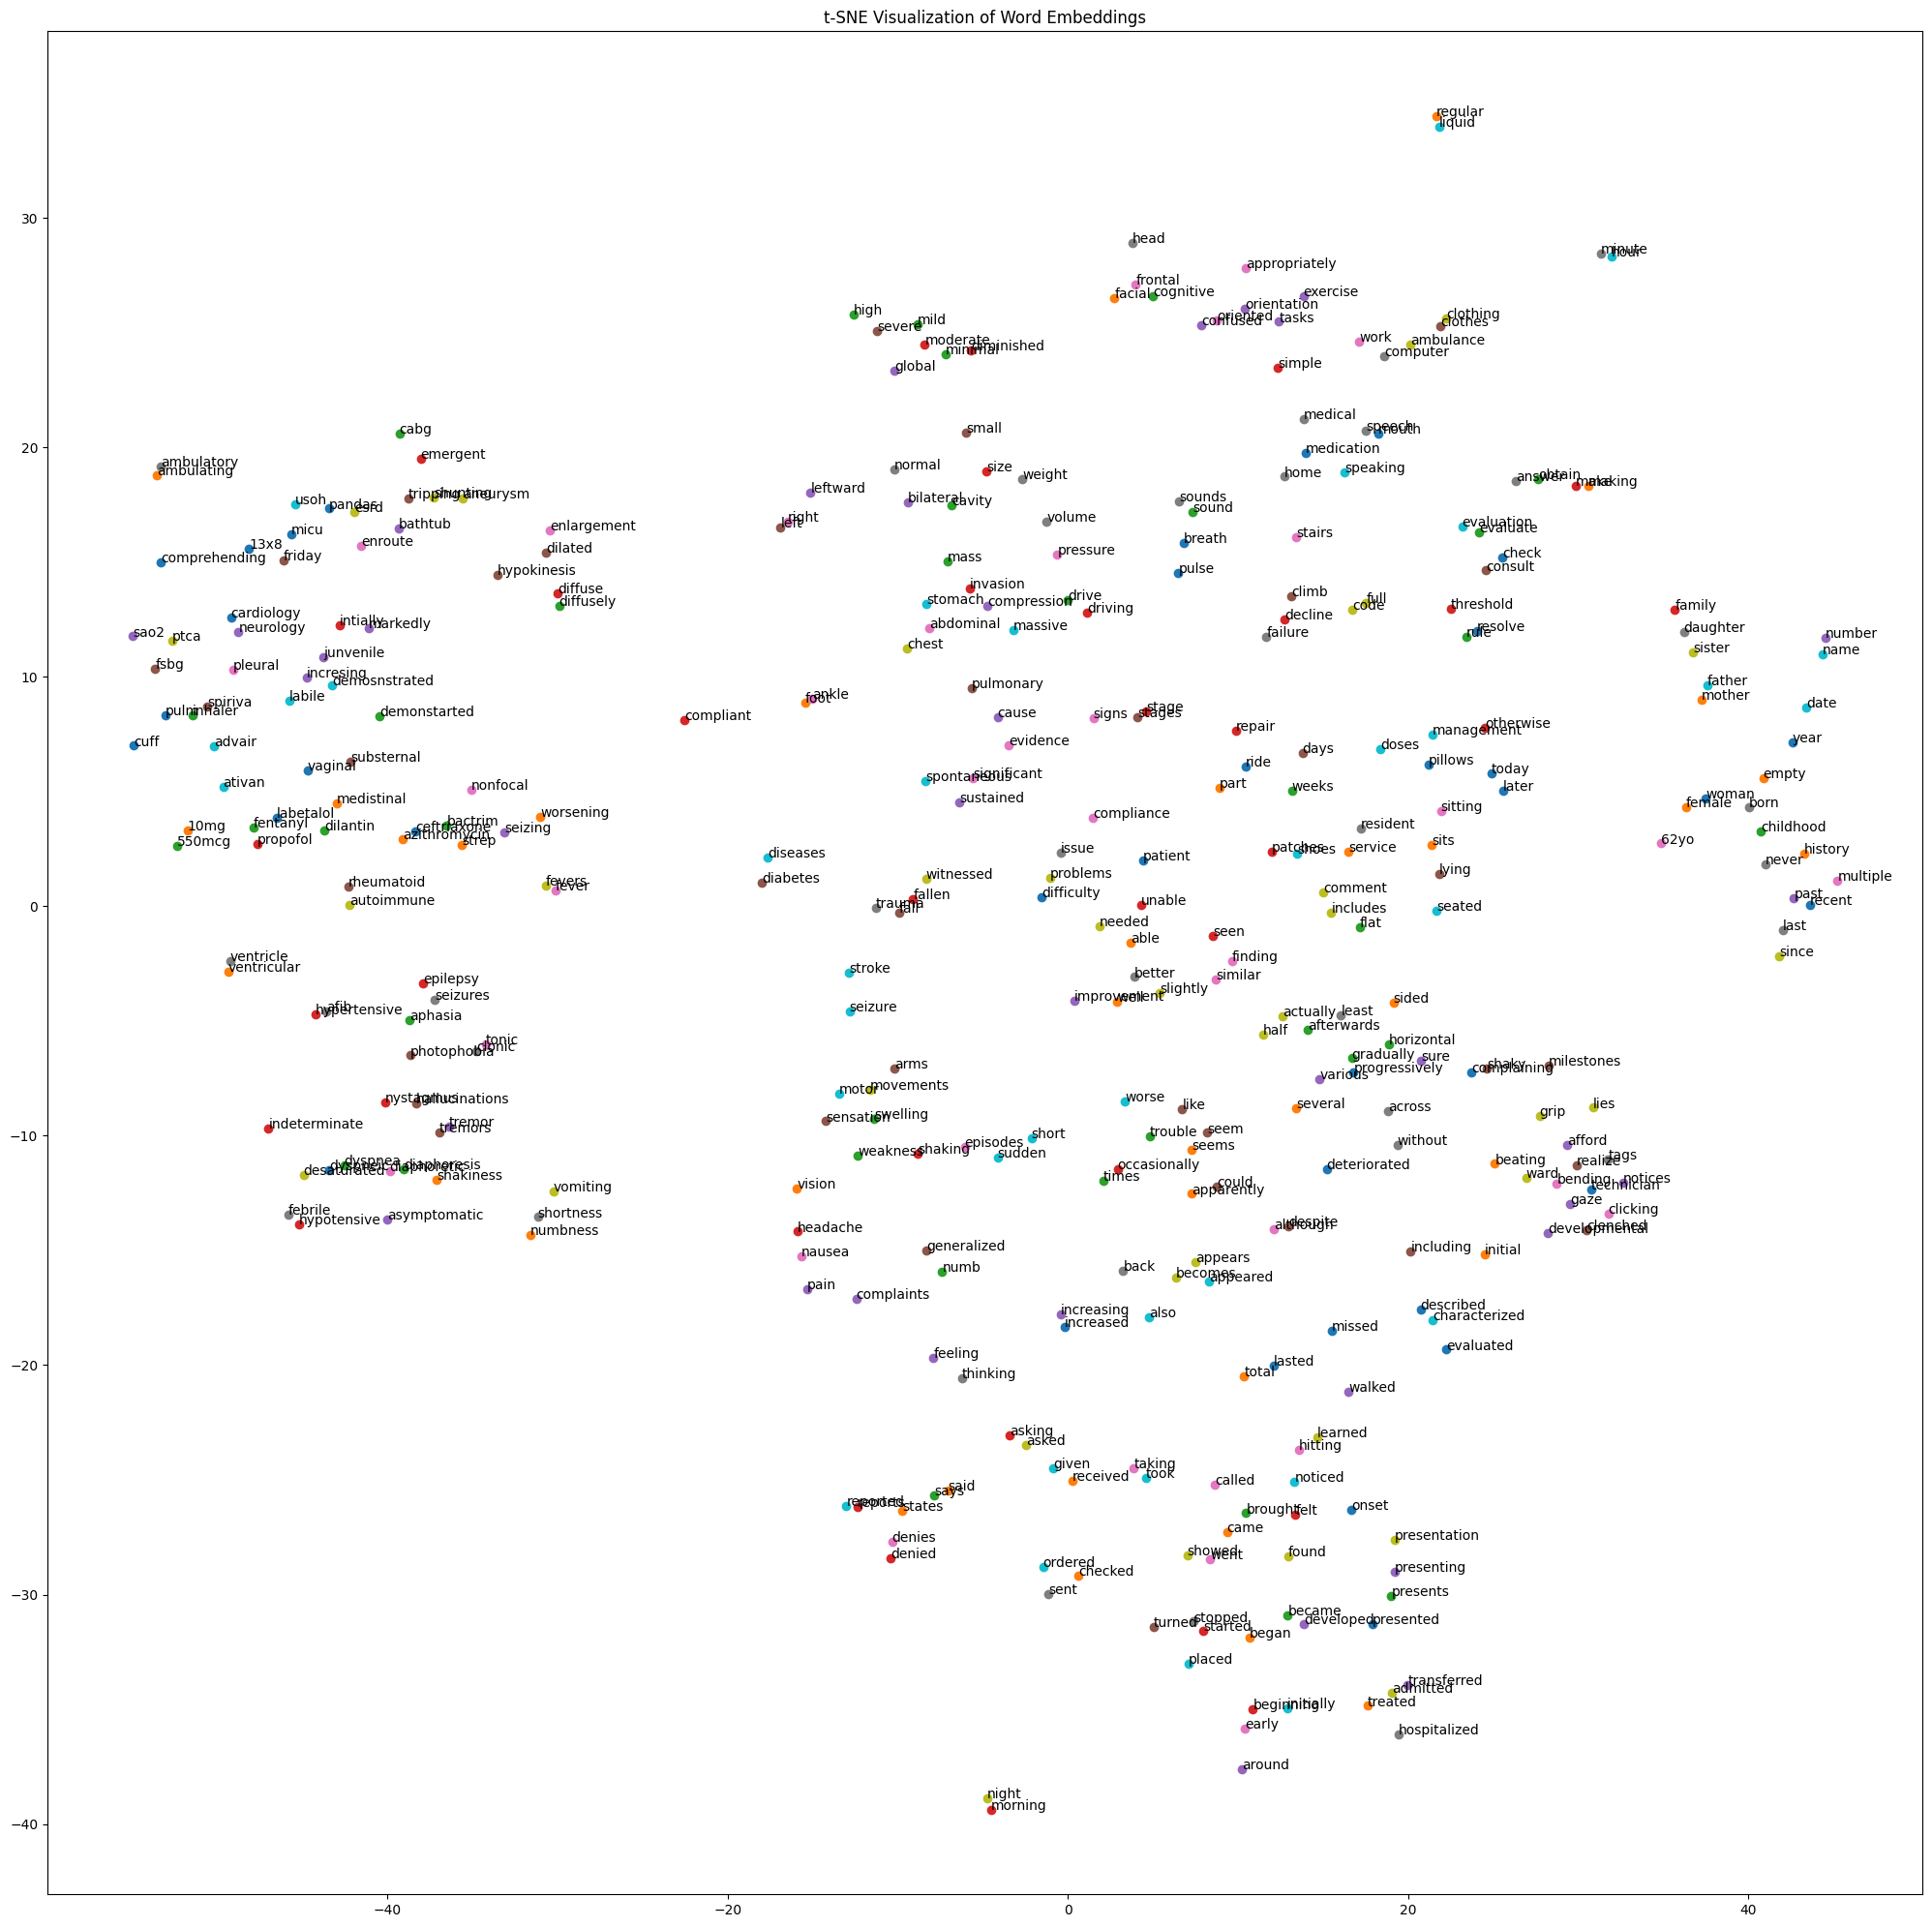

In [27]:
# Visualization of all notes using ClinicalBert

# Load the BERT model and tokenizer
clinical_model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
clinical_tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
clinical_model.eval()


# Example input text
input_text = clean_text(all_notes_combined)

# Tokenize the input text using the BERT tokenizer
#input_tokens = clinical_tokenizer.tokenize(input_text)
input_tokens = input_text.split()
# Initialize an empty list to store word embeddings
word_embs = []

for token in input_tokens:
    # Check if the token is a valid word
    if token not in string.punctuation:
        # Encode the token using the BERT model
        inputs = clinical_tokenizer(token, return_tensors="pt")
        with torch.no_grad():
            outputs = clinical_model(**inputs)
        token_emb = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        word_embs.append(token_emb)

# Perform t-SNE dimensionality reduction
tsne_model = TSNE(n_components=2, perplexity=10, random_state=42)
word_embs_2d = tsne_model.fit_transform(np.array(word_embs))

# Create a scatter plot of the word embeddings in 2D space
plt.figure(figsize=(25, 25))
for i in range(len(word_embs_2d)):
    plt.scatter(word_embs_2d[i, 0], word_embs_2d[i, 1])
    plt.annotate(input_tokens[i], (word_embs_2d[i, 0], word_embs_2d[i, 1]))

plt.title("t-SNE Visualization of Word Embeddings")
plt.show()

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: emilyalsentzer/Bio_ClinicalBERT
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.decoder.weight             | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


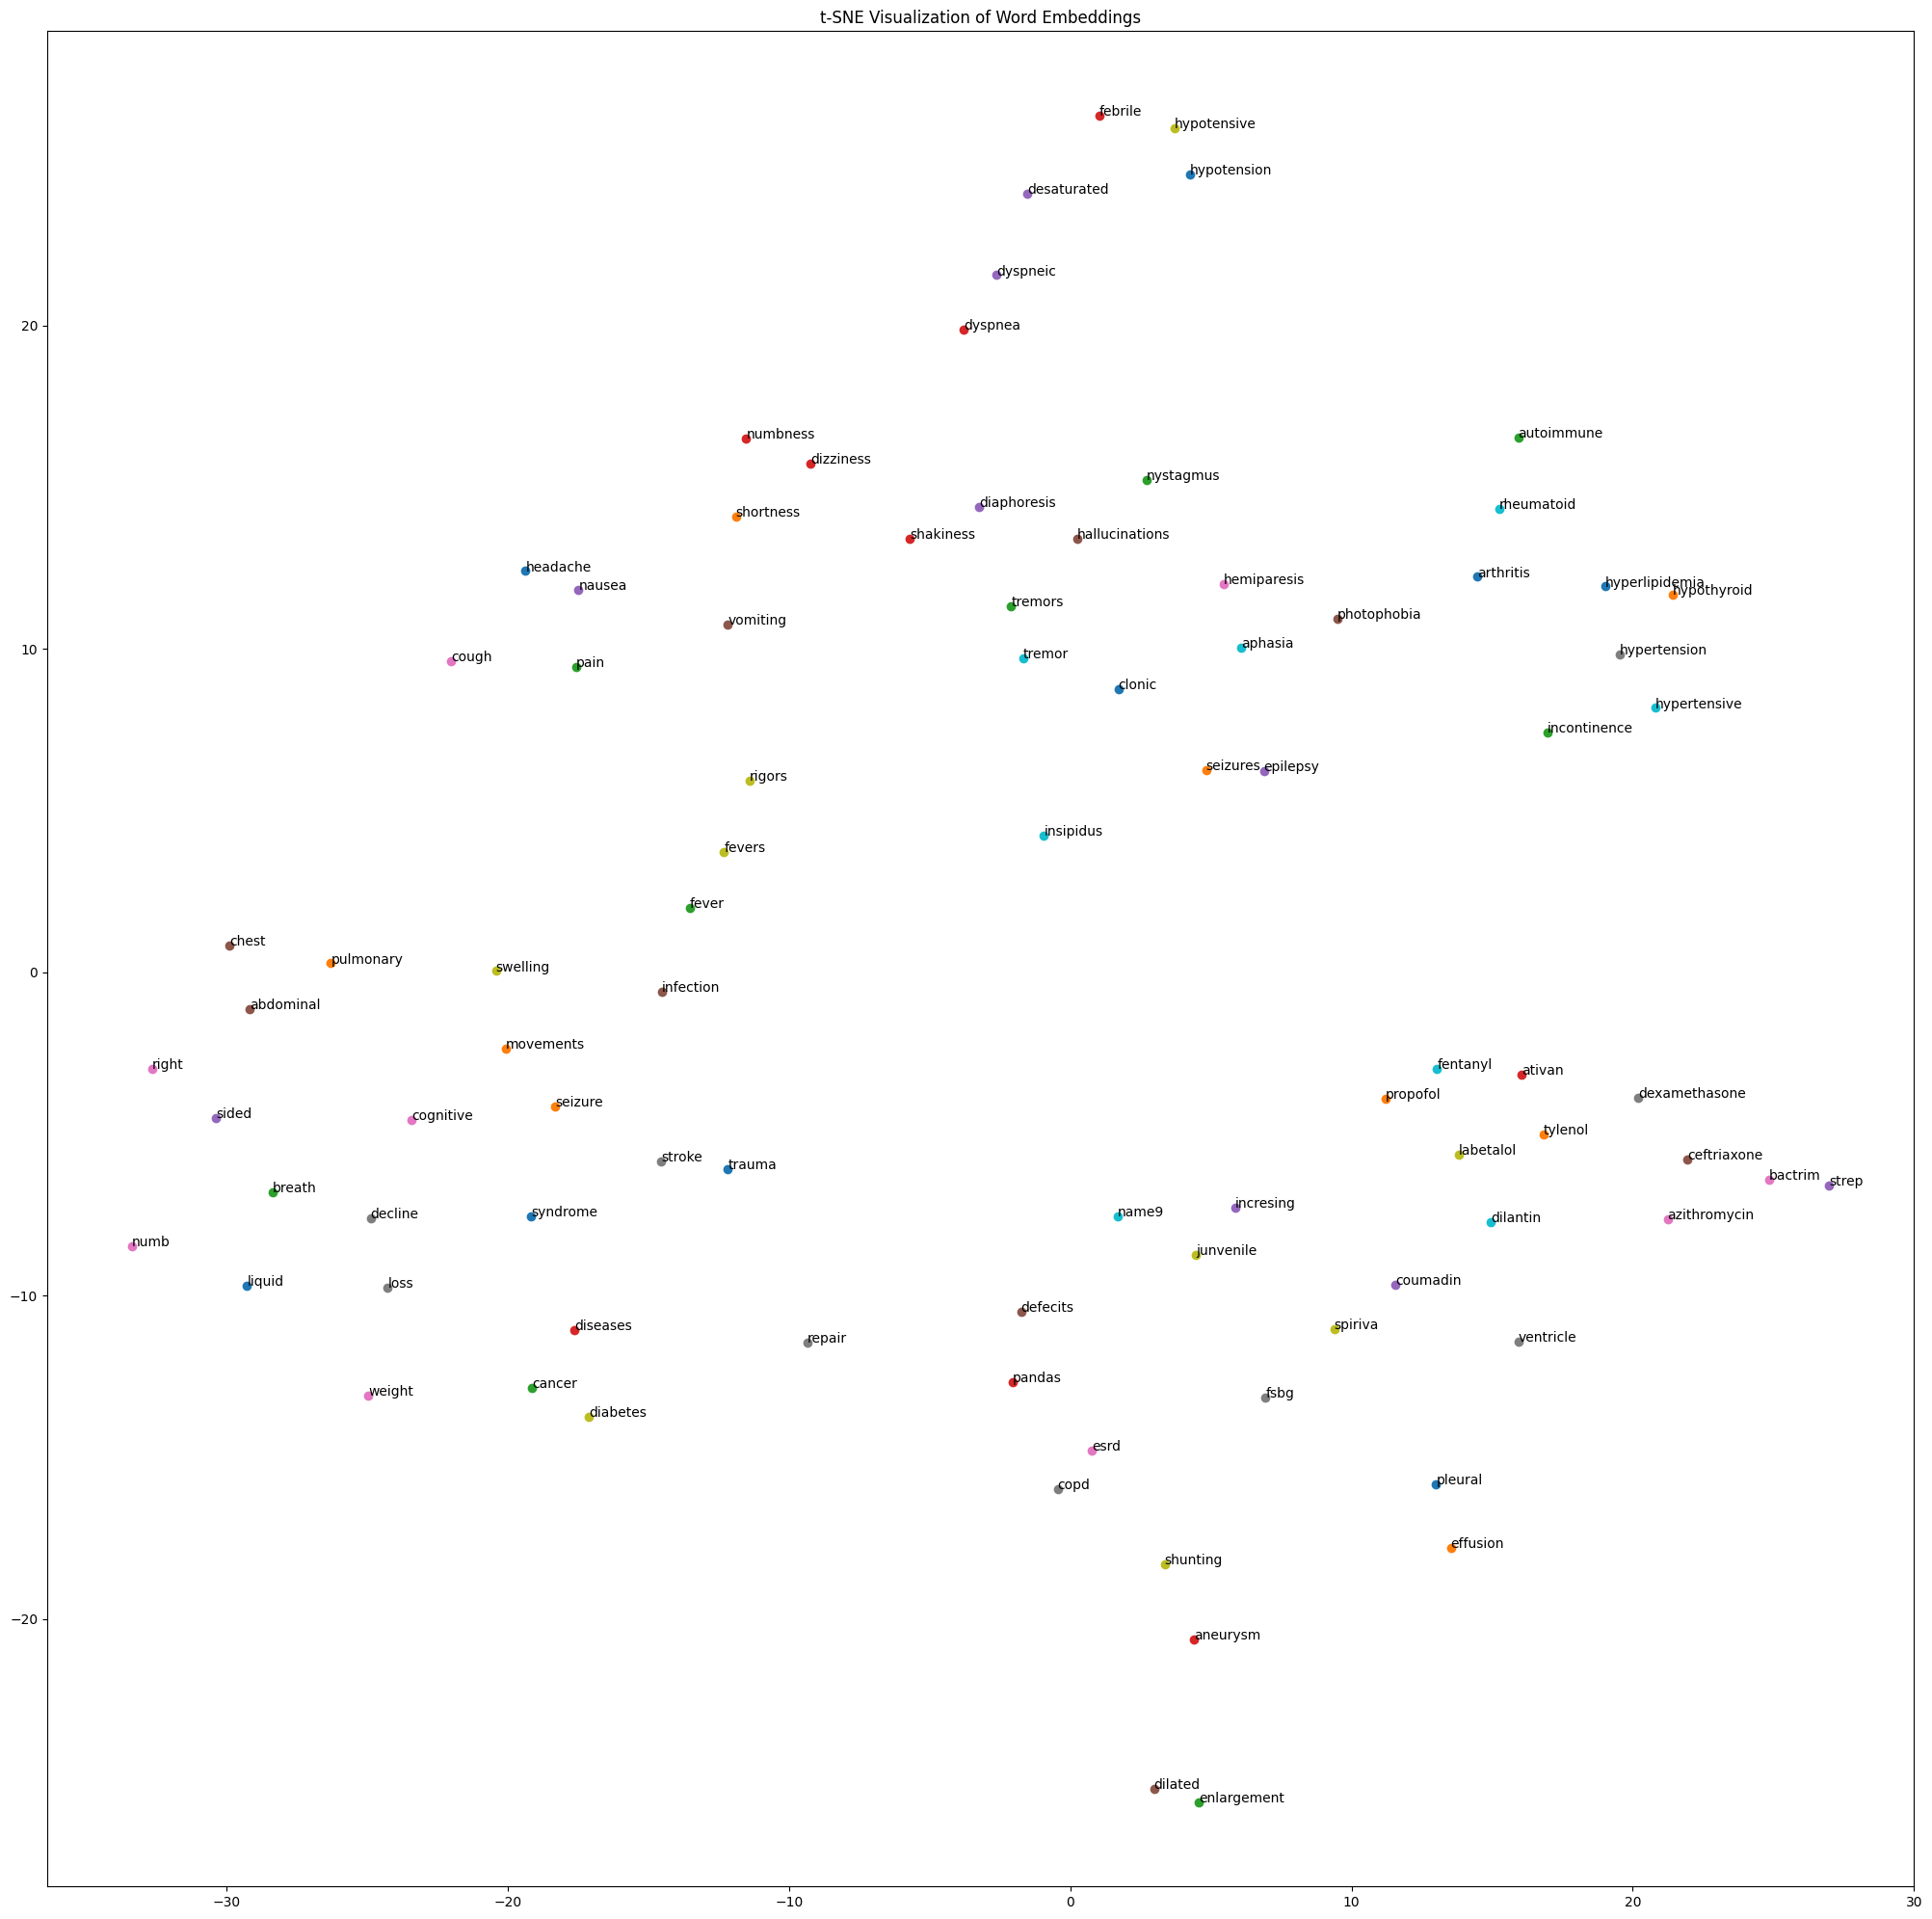

In [28]:
# Visualization of notes filtered with SciSpacy using ClinicalBert


# Load the BERT model and tokenizer
clinical_model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
clinical_tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
clinical_model.eval()


# Example input text
input_text = clean_text(notes_combined)

# Tokenize the input text using the BERT tokenizer
#input_tokens = clinical_tokenizer.tokenize(input_text)
input_tokens = input_text.split()
# Initialize an empty list to store word embeddings
word_embs = []

for token in input_tokens:
    # Check if the token is a valid word
    if token not in string.punctuation:
        # Encode the token using the BERT model
        inputs = clinical_tokenizer(token, return_tensors="pt")
        with torch.no_grad():
            outputs = clinical_model(**inputs)
        token_emb = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        word_embs.append(token_emb)

# Perform t-SNE dimensionality reduction
tsne_model = TSNE(n_components=2, perplexity=10, random_state=42)
word_embs_2d = tsne_model.fit_transform(np.array(word_embs))

# Create a scatter plot of the word embeddings in 2D space
plt.figure(figsize=(25, 25))
for i in range(len(word_embs_2d)):
    plt.scatter(word_embs_2d[i, 0], word_embs_2d[i, 1])
    plt.annotate(input_tokens[i], (word_embs_2d[i, 0], word_embs_2d[i, 1]))

plt.title("t-SNE Visualization of Word Embeddings")
plt.show()

**Bio-Bert model**

In [29]:
for i in range(len(notes)):
  text = notes[i]
  word = words[i] # words not recognized by the model will return nan, rest of the words will get embeddings
  # text = clean_text(text)
  biobert_model.eval()
  # Get the embedding for the sentence, as well as an embedding for words
  (sen_emb, word_emb) = get_embedding(biobert_model, biobert_tokenizer, text, word)
  print('Embedding sizes:')
  print(sen_emb.shape)
  print(word_emb.shape)
  print(sen_emb)
  print(f'word embeddings for {word}')
  print(word_emb)

50 year old female presents after having fallen in the bathtub 4 days ago and hitting the back of her head. Since then she has had a massive [MASK]" which did not resolve with Tylenol. She states that she has a high threshold for pain and did not realize how bad it was during the day while at work but then when she got home at night she noticed it. The patient noticed ""silvery spects"" in her vision and she had trouble with some simple tasks like finding the tags on the back of her clothing in the morning. She reported that she had to check several times to make sure she did not put her clothes on backwards. She has had some dizziness, but no nausea or vomiting. Her speech has not been affected.
[101, 1851, 1214, 1385, 2130, 8218, 1170, 1515, 4984, 1107, 1103, 10919, 25098, 125, 1552, 2403, 1105, 6886, 1103, 1171, 1104, 1123, 1246, 119, 1967, 1173, 1131, 1144, 1125, 170, 4672, 103, 107, 1134, 1225, 1136, 10820, 1114, 5331, 7836, 4063, 119, 1153, 2231, 1115, 1131, 1144, 170, 1344, 1181

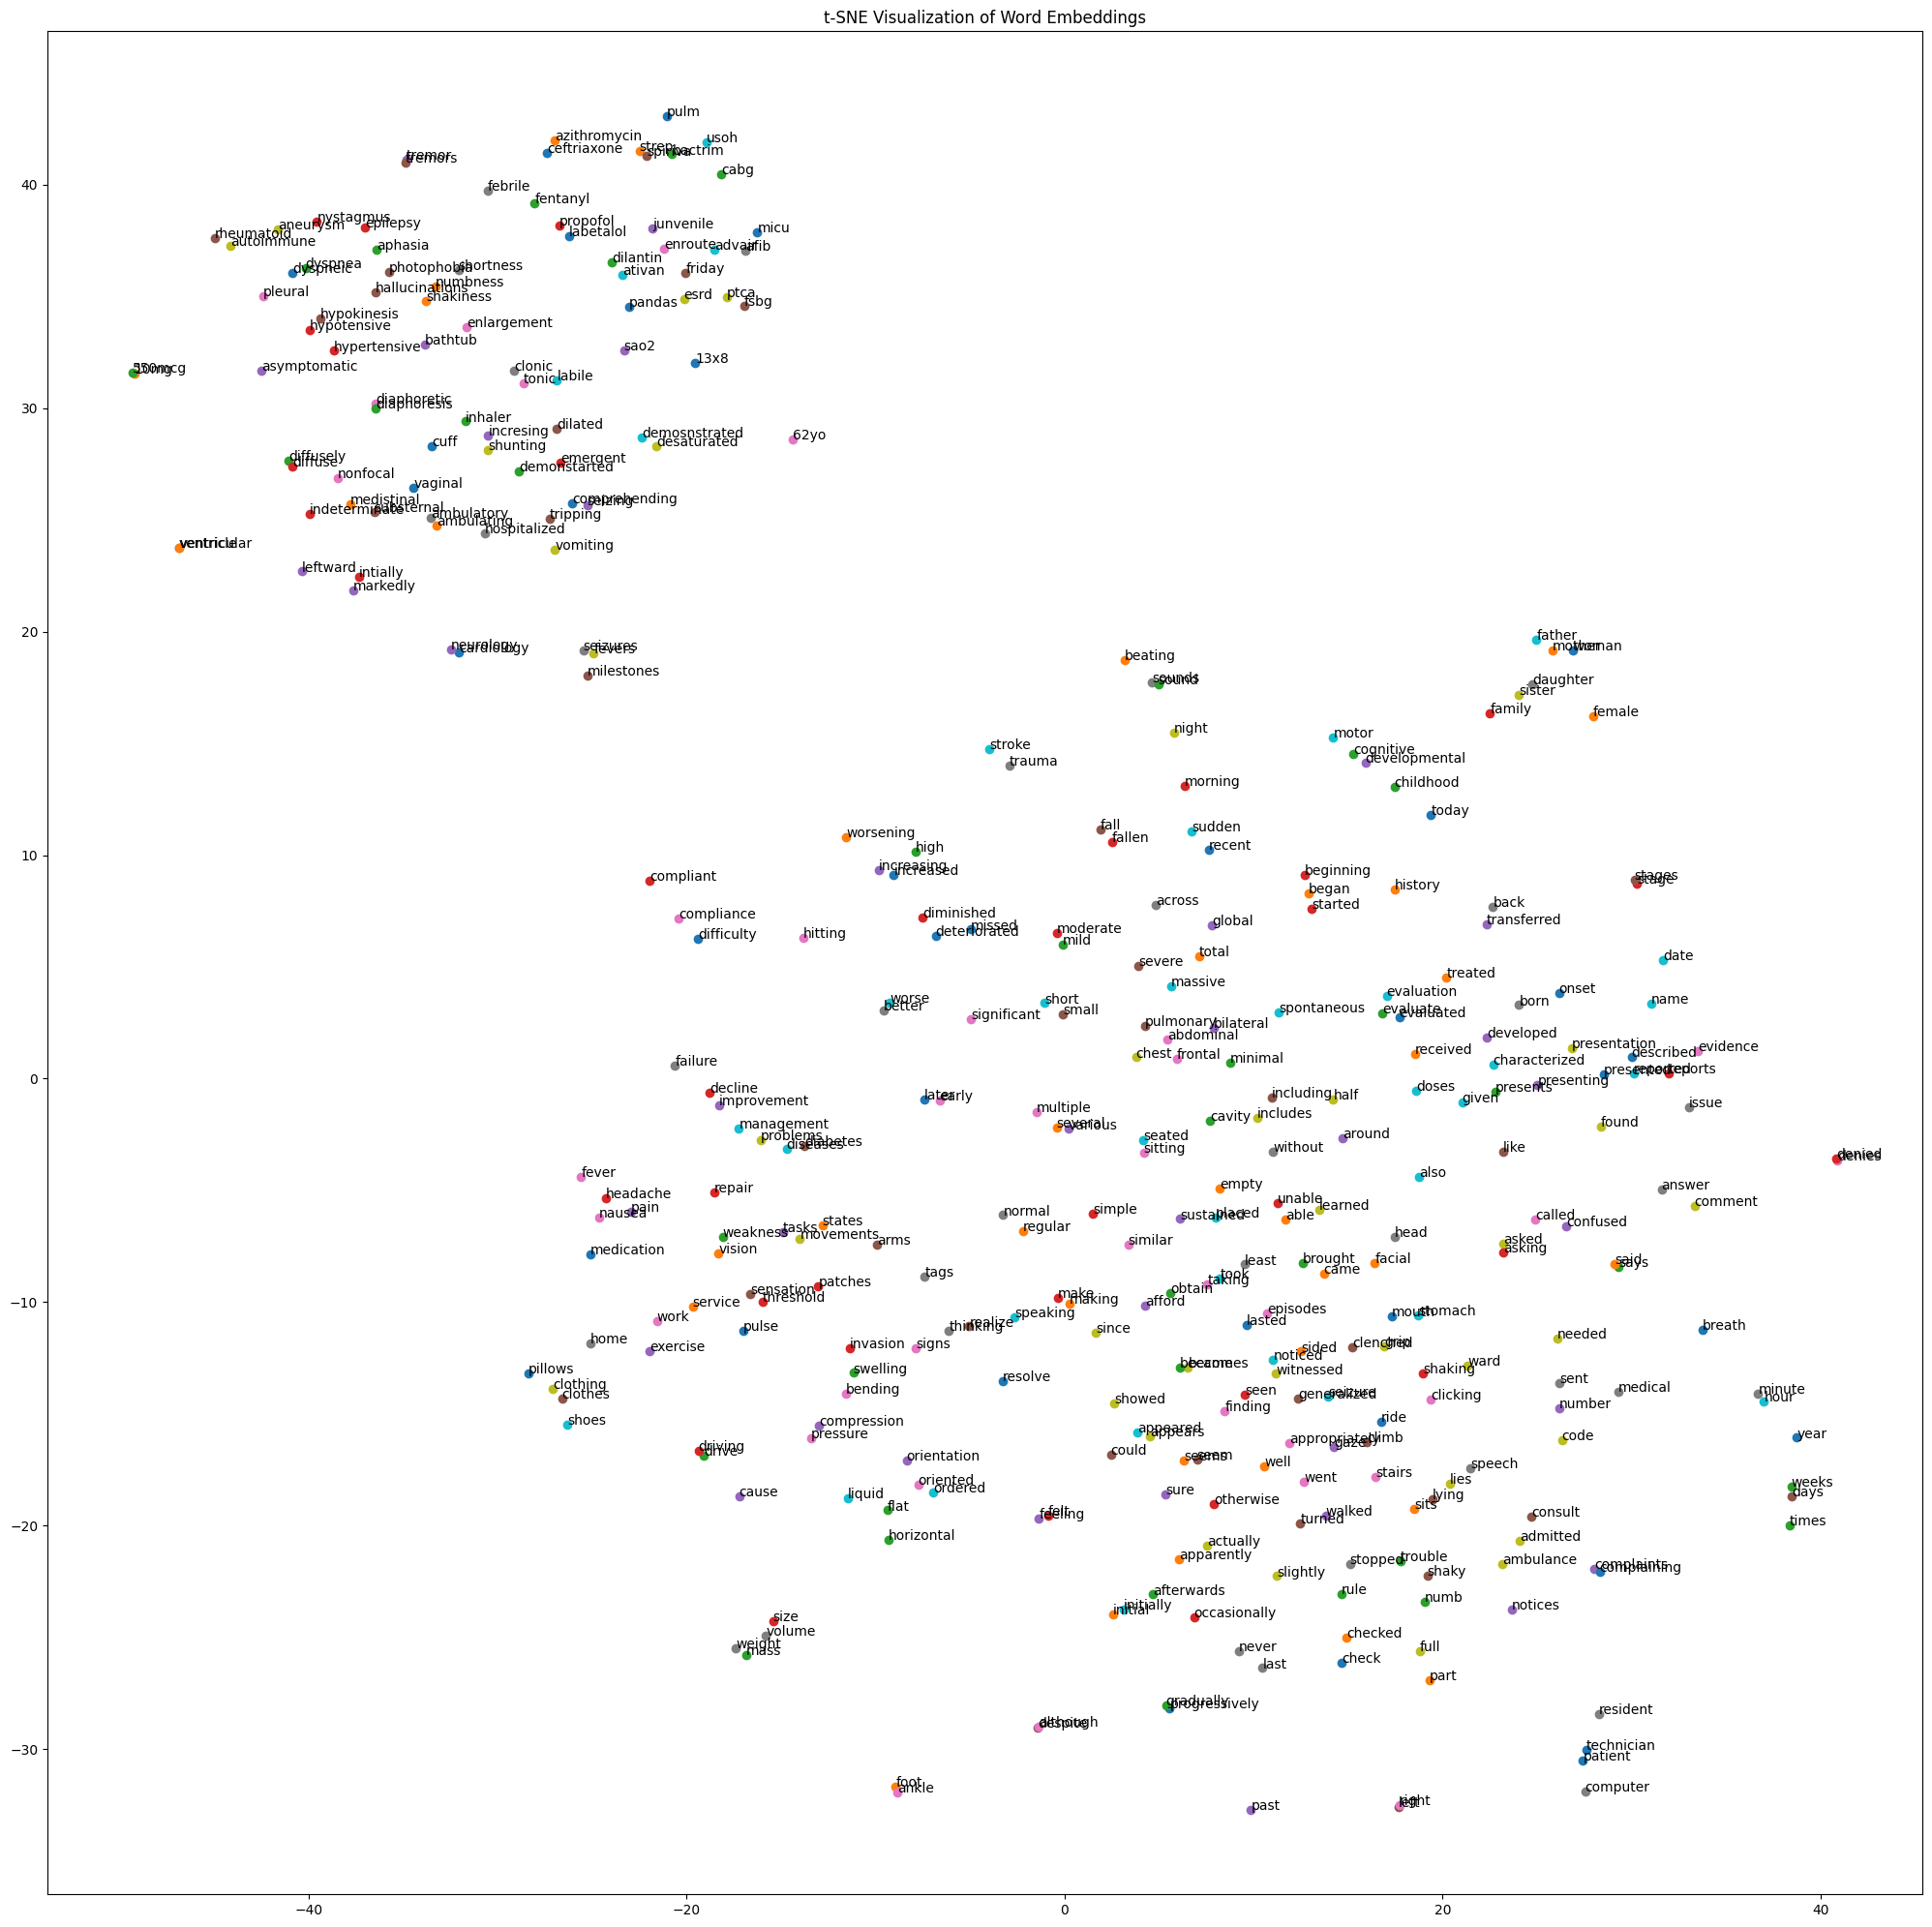

In [30]:
# Visualization of all notes using BioBert

# Load the BERT model
biobert_model.eval()


# Example input text
input_text = clean_text(all_notes_combined)

# Tokenize the input text using the BERT tokenizer
#input_tokens = biobert_tokenizer.tokenize(input_text)
input_tokens = input_text.split()
# Initialize an empty list to store word embeddings
word_embs = []

for token in input_tokens:
    # Check if the token is a valid word
    if token not in string.punctuation:
        # Encode the token using the BERT model
        inputs = biobert_tokenizer(token, return_tensors="pt")
        with torch.no_grad():
            outputs = biobert_model(**inputs)
        token_emb = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        word_embs.append(token_emb)

# Perform t-SNE dimensionality reduction
tsne_model = TSNE(n_components=2, perplexity=10, random_state=42)
word_embs_2d = tsne_model.fit_transform(np.array(word_embs))

# Create a scatter plot of the word embeddings in 2D space
plt.figure(figsize=(25, 25))
for i in range(len(word_embs_2d)):
    plt.scatter(word_embs_2d[i, 0], word_embs_2d[i, 1])
    plt.annotate(input_tokens[i], (word_embs_2d[i, 0], word_embs_2d[i, 1]))

plt.title("t-SNE Visualization of Word Embeddings")
plt.show()


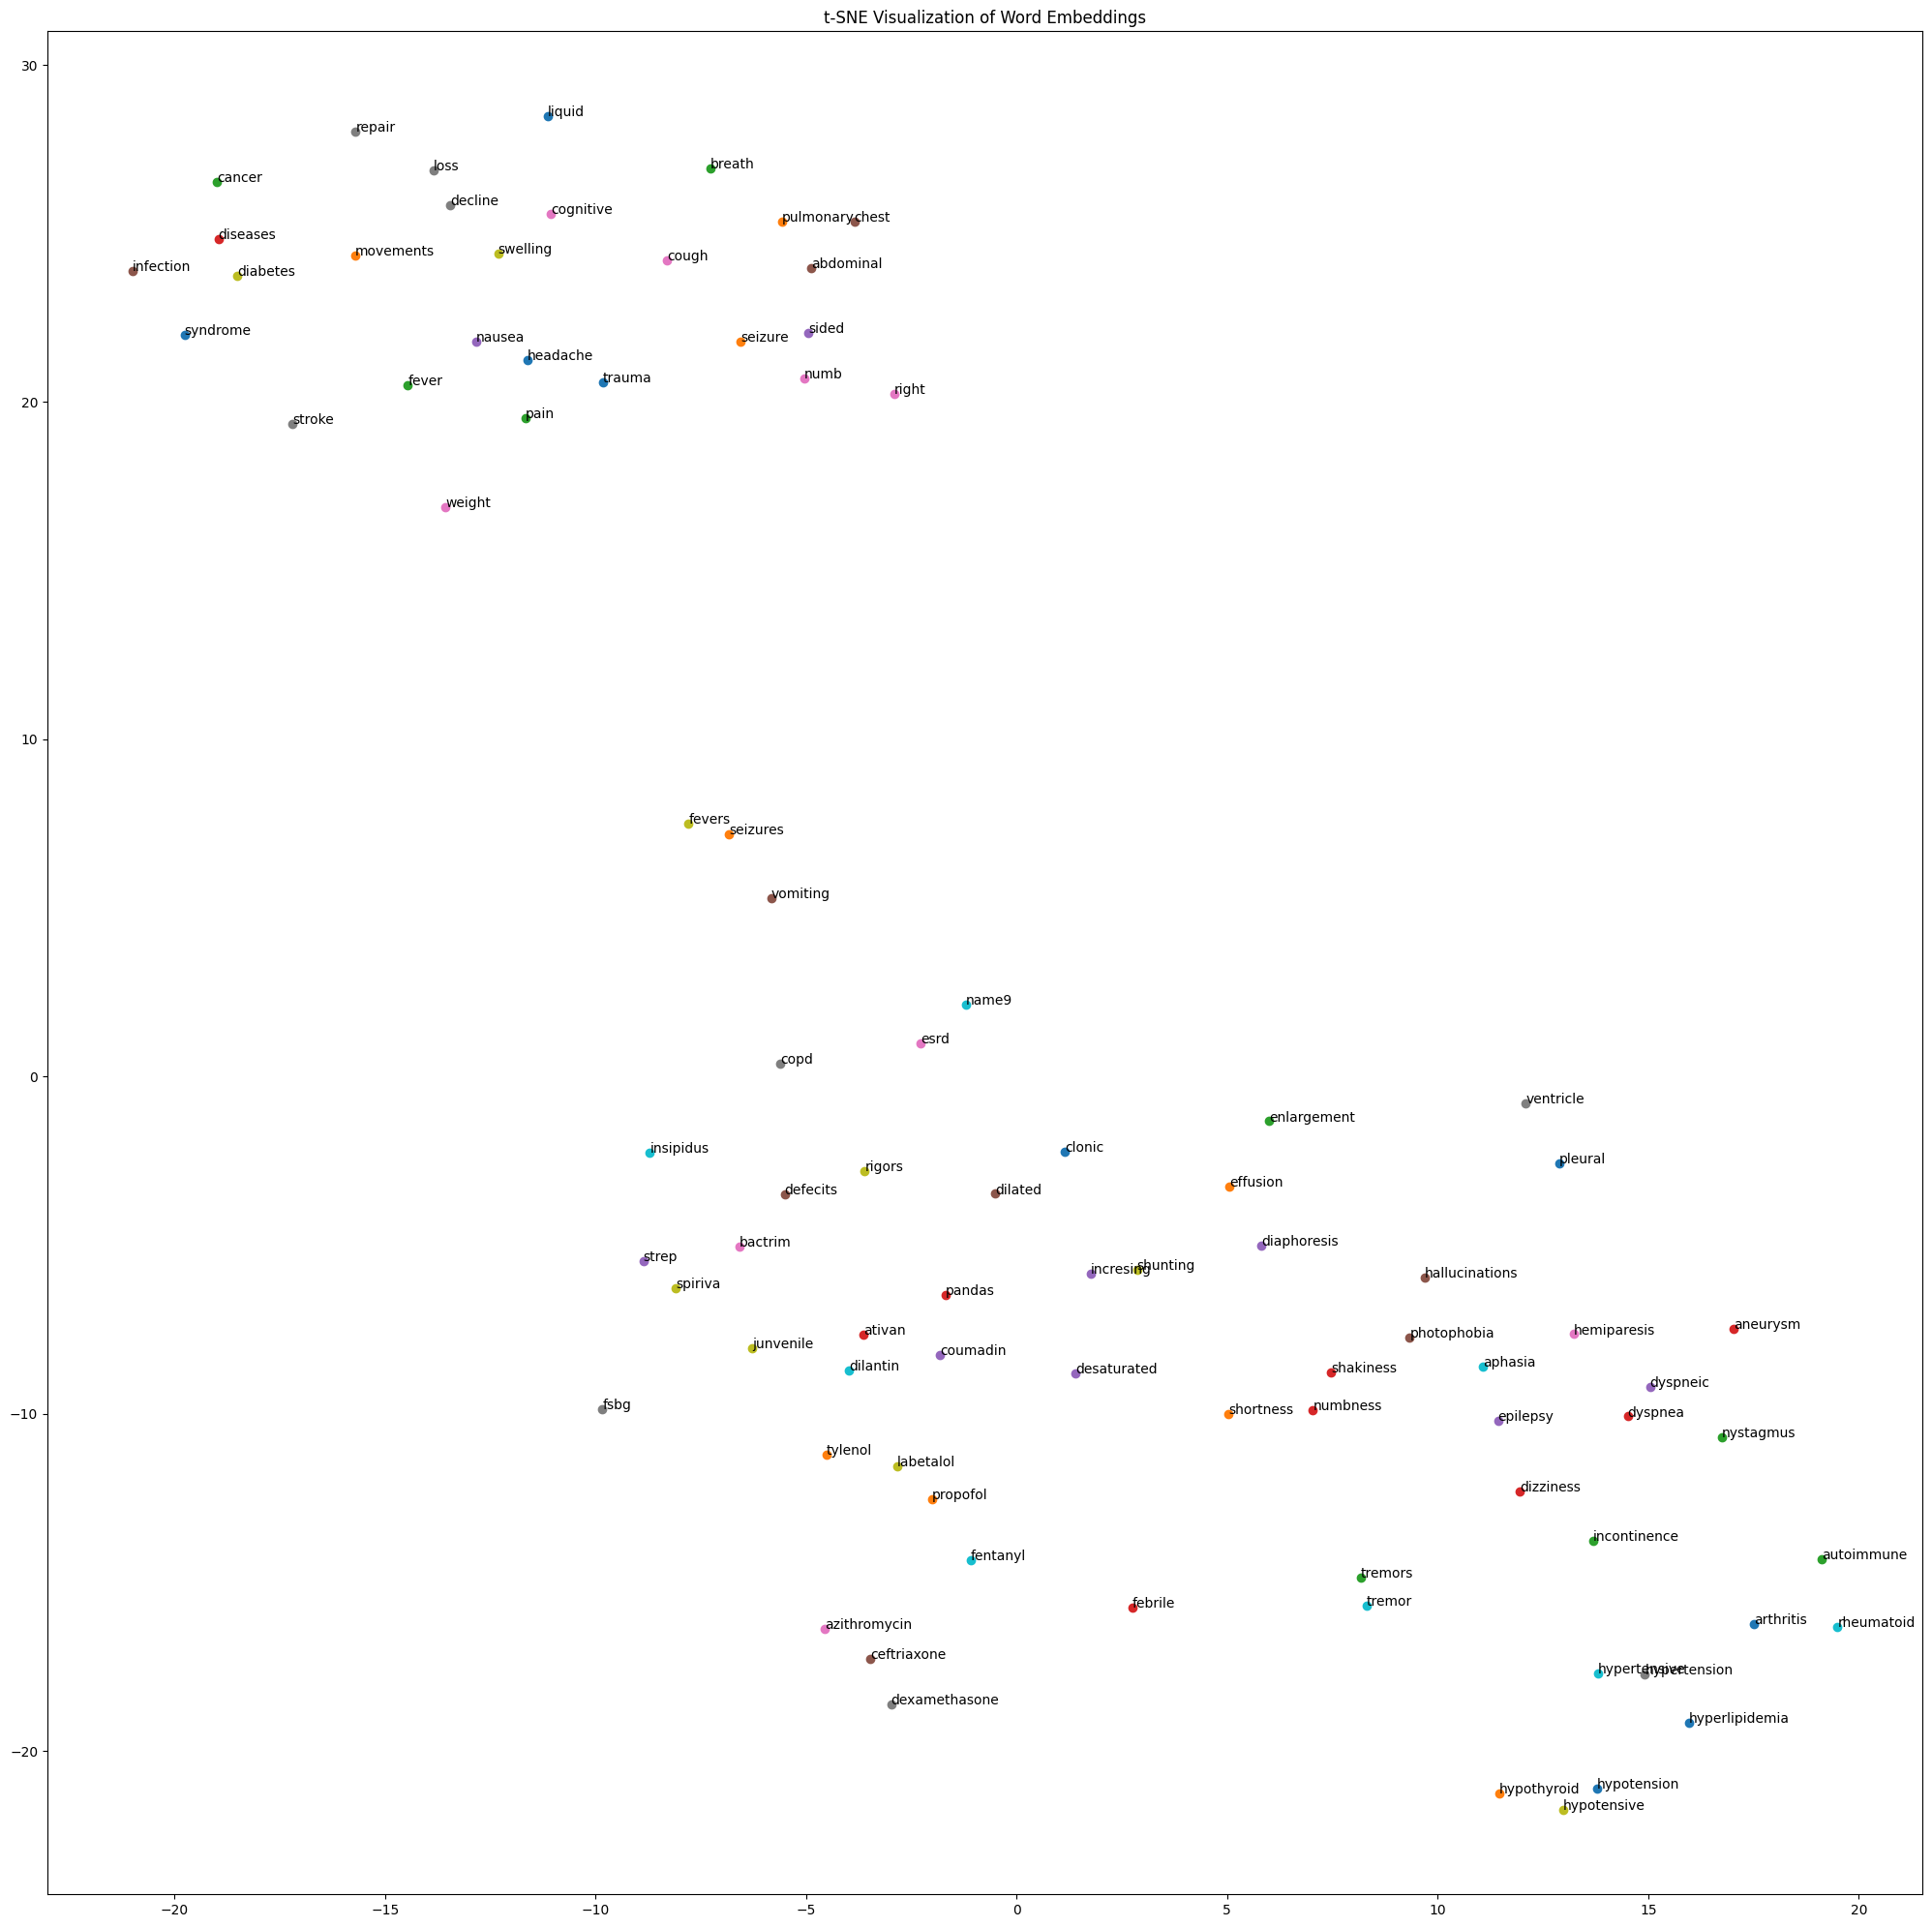

In [31]:
# Visualization of SciSpacy filteres notes using BioBert

# Load the BERT model
biobert_model.eval()


# Example input text
input_text = clean_text(notes_combined)

# Tokenize the input text using the BERT tokenizer
#input_tokens = biobert_tokenizer.tokenize(input_text)
input_tokens = input_text.split()
# Initialize an empty list to store word embeddings
word_embs = []

for token in input_tokens:
    # Check if the token is a valid word
    if token not in string.punctuation:
        # Encode the token using the BERT model
        inputs = biobert_tokenizer(token, return_tensors="pt")
        with torch.no_grad():
            outputs = biobert_model(**inputs)
        token_emb = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        word_embs.append(token_emb)

# Perform t-SNE dimensionality reduction
tsne_model = TSNE(n_components=2, perplexity=10, random_state=42)
word_embs_2d = tsne_model.fit_transform(np.array(word_embs))

# Create a scatter plot of the word embeddings in 2D space
plt.figure(figsize=(25, 25))
for i in range(len(word_embs_2d)):
    plt.scatter(word_embs_2d[i, 0], word_embs_2d[i, 1])
    plt.annotate(input_tokens[i], (word_embs_2d[i, 0], word_embs_2d[i, 1]))

plt.title("t-SNE Visualization of Word Embeddings")
plt.show()


**Blue Bert model**

In [32]:
for i in range(len(notes)):
  text = notes[i]
  word = words[i]
  # text = clean_text(text)
  blue_bert_model.eval()
  # Get the embedding for the sentence, as well as an embedding for word
  (sen_emb, word_emb) = get_embedding(blue_bert_model, blue_tokenizer, text, word)
  print('Embedding sizes:')
  print(sen_emb.shape)
  print(word_emb.shape)
  print(sen_emb)
  print(f'word embedding for {word}')
  print(word_emb)

50 year old female presents after having fallen in the bathtub 4 days ago and hitting the back of her head. Since then she has had a massive [MASK]" which did not resolve with Tylenol. She states that she has a high threshold for pain and did not realize how bad it was during the day while at work but then when she got home at night she noticed it. The patient noticed ""silvery spects"" in her vision and she had trouble with some simple tasks like finding the tags on the back of her clothing in the morning. She reported that she had to check several times to make sure she did not put her clothes on backwards. She has had some dizziness, but no nausea or vomiting. Her speech has not been affected.
[101, 2753, 2095, 2214, 2931, 7534, 2044, 2383, 5357, 1999, 1996, 7198, 28251, 1018, 2420, 3283, 1998, 7294, 1996, 2067, 1997, 2014, 2132, 1012, 100, 2059, 2016, 2038, 2018, 1037, 5294, 103, 1000, 2029, 2106, 2025, 10663, 2007, 100, 1012, 100, 2163, 2008, 2016, 2038, 1037, 2152, 11207, 2005, 3

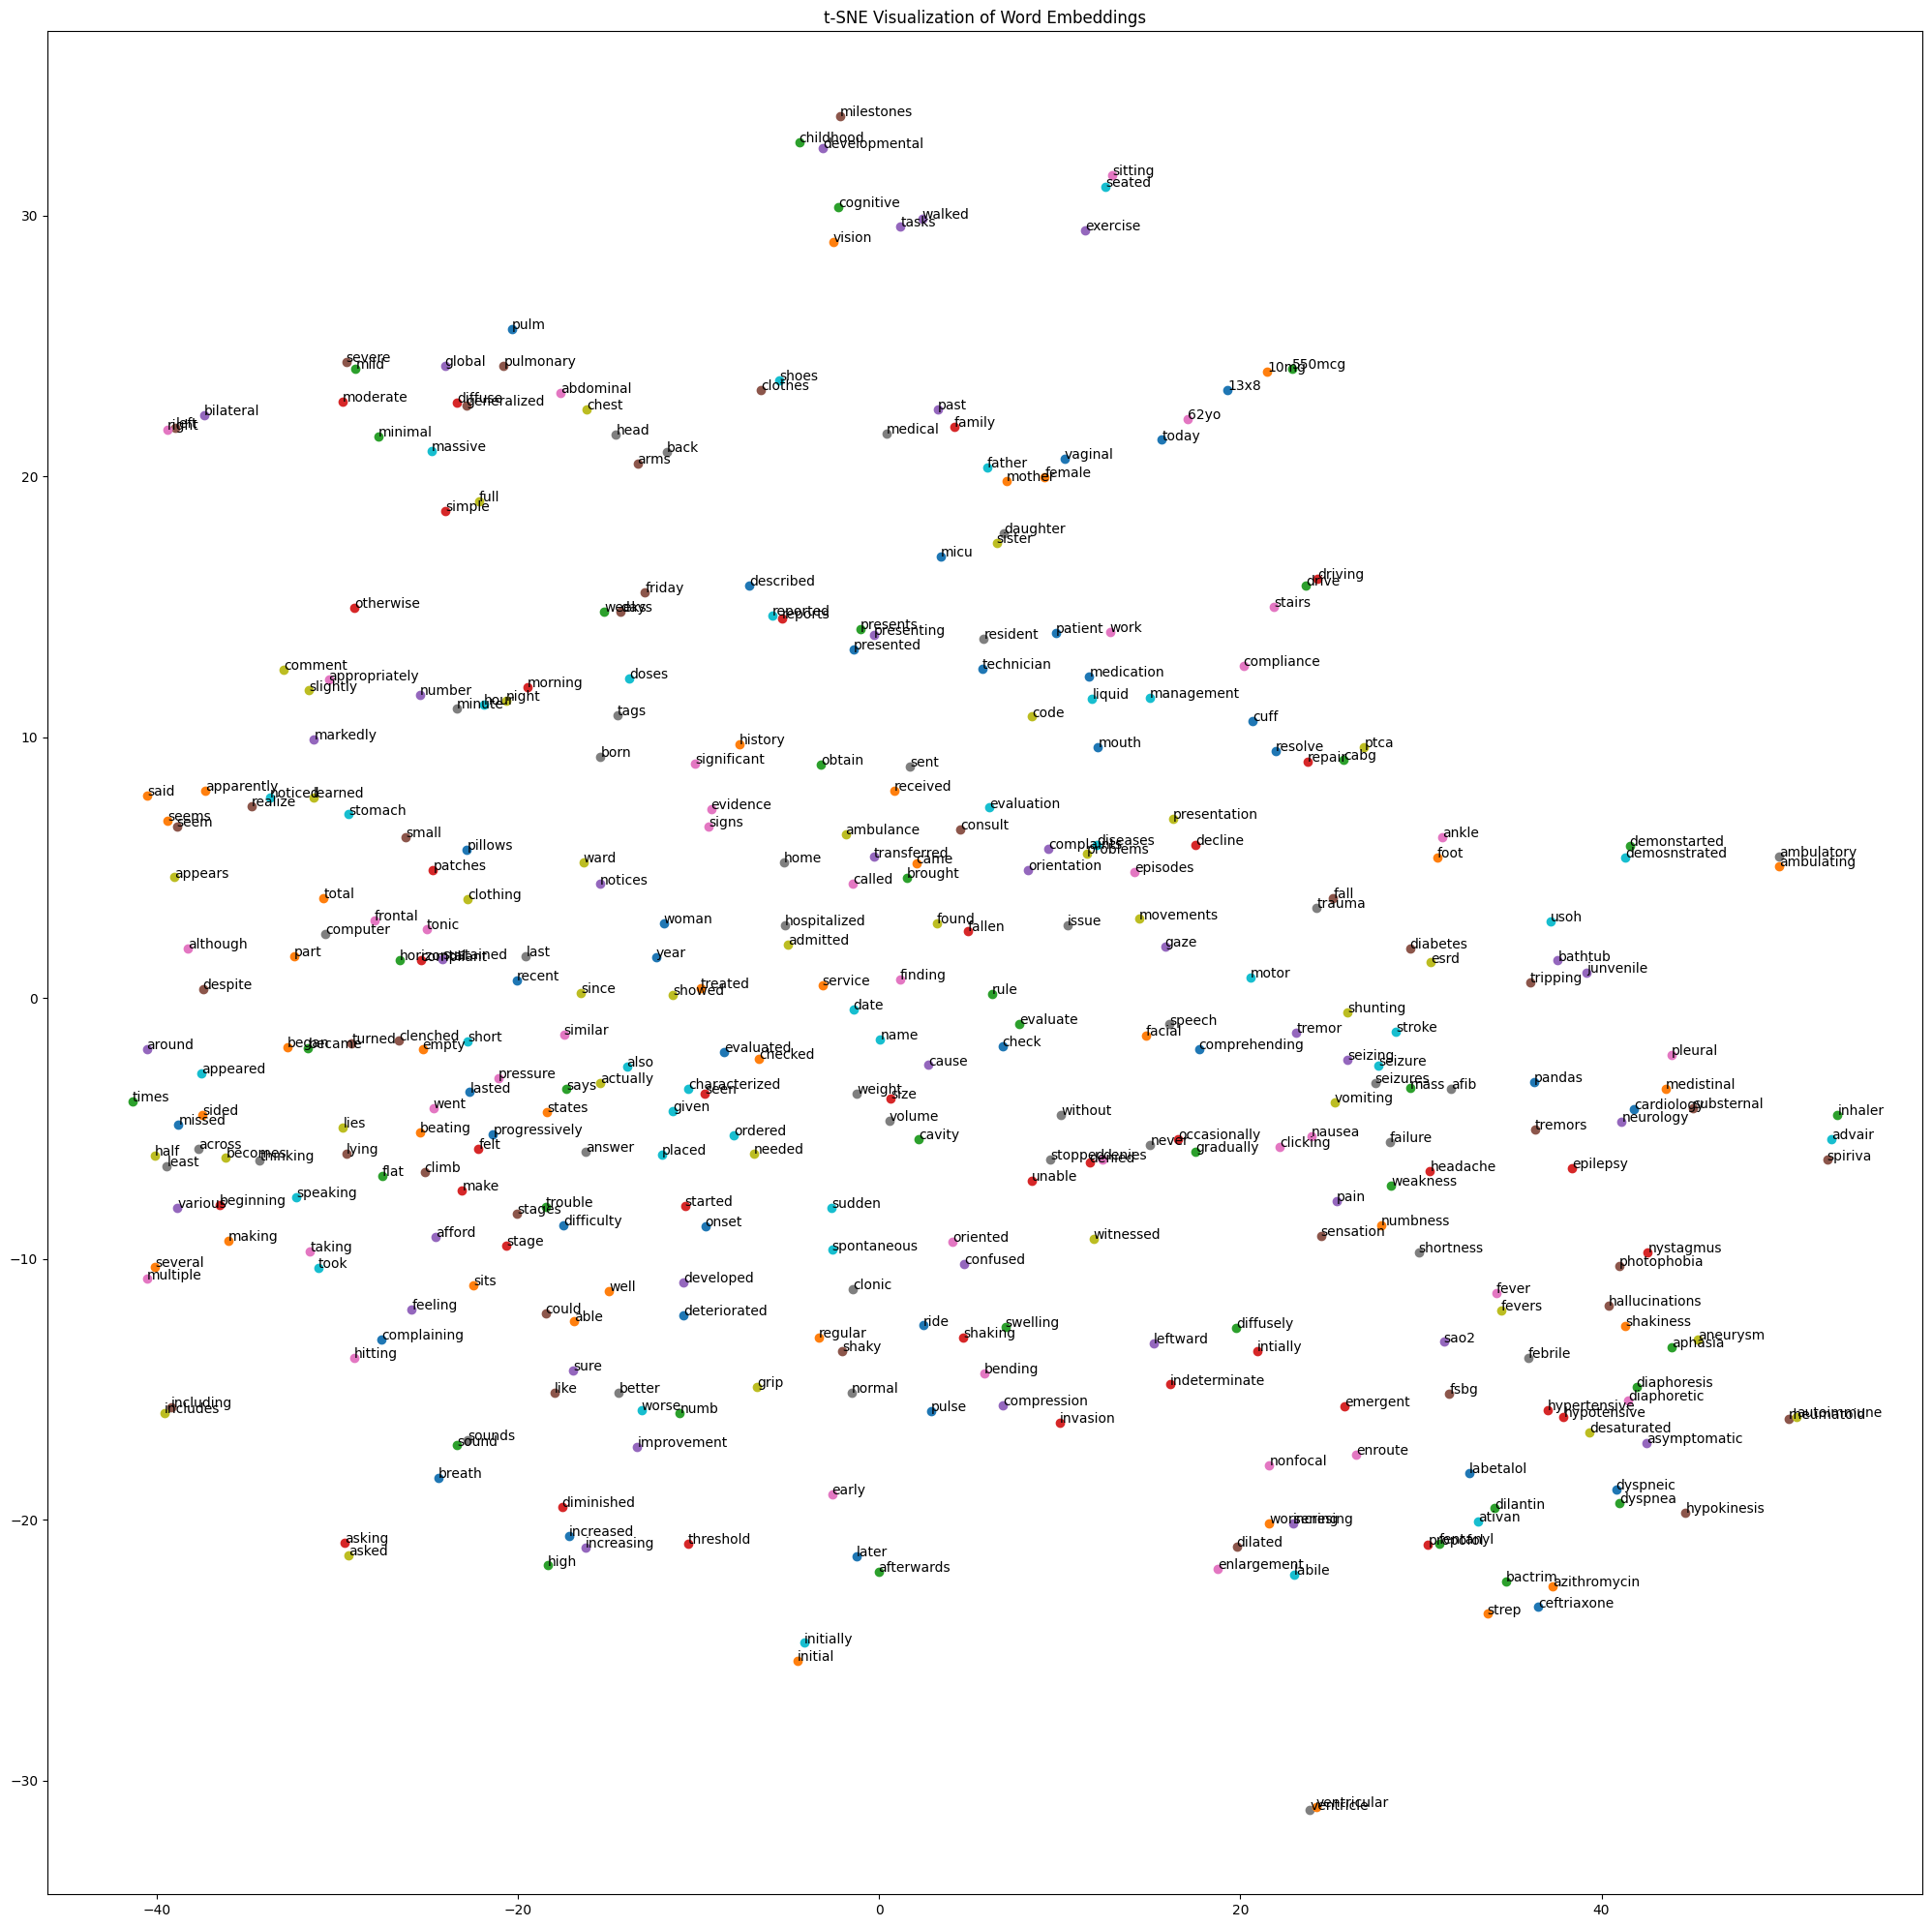

In [33]:
# Visualization of all notes using BlueBert


# Load the BERT model
blue_bert_model.eval()


# Example input text
input_text = clean_text(all_notes_combined)

# Tokenize the input text using the BERT tokenizer
#input_tokens = blue_tokenizer.tokenize(input_text)
input_tokens = input_text.split()

# Initialize an empty list to store word embeddings
word_embs = []

for token in input_tokens:
    # Check if the token is a valid word
    if token not in string.punctuation:
        # Encode the token using the BERT model
        inputs = blue_tokenizer(token, return_tensors="pt")
        with torch.no_grad():
            outputs = blue_bert_model(**inputs)
        token_emb = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        word_embs.append(token_emb)

# Perform t-SNE dimensionality reduction
tsne_model = TSNE(n_components=2, perplexity=10, random_state=42)
word_embs_2d = tsne_model.fit_transform(np.array(word_embs))

# Create a scatter plot of the word embeddings in 2D space
plt.figure(figsize=(25, 25))
for i in range(len(word_embs_2d)):
    plt.scatter(word_embs_2d[i, 0], word_embs_2d[i, 1])
    plt.annotate(input_tokens[i], (word_embs_2d[i, 0], word_embs_2d[i, 1]))

plt.title("t-SNE Visualization of Word Embeddings")
plt.show()


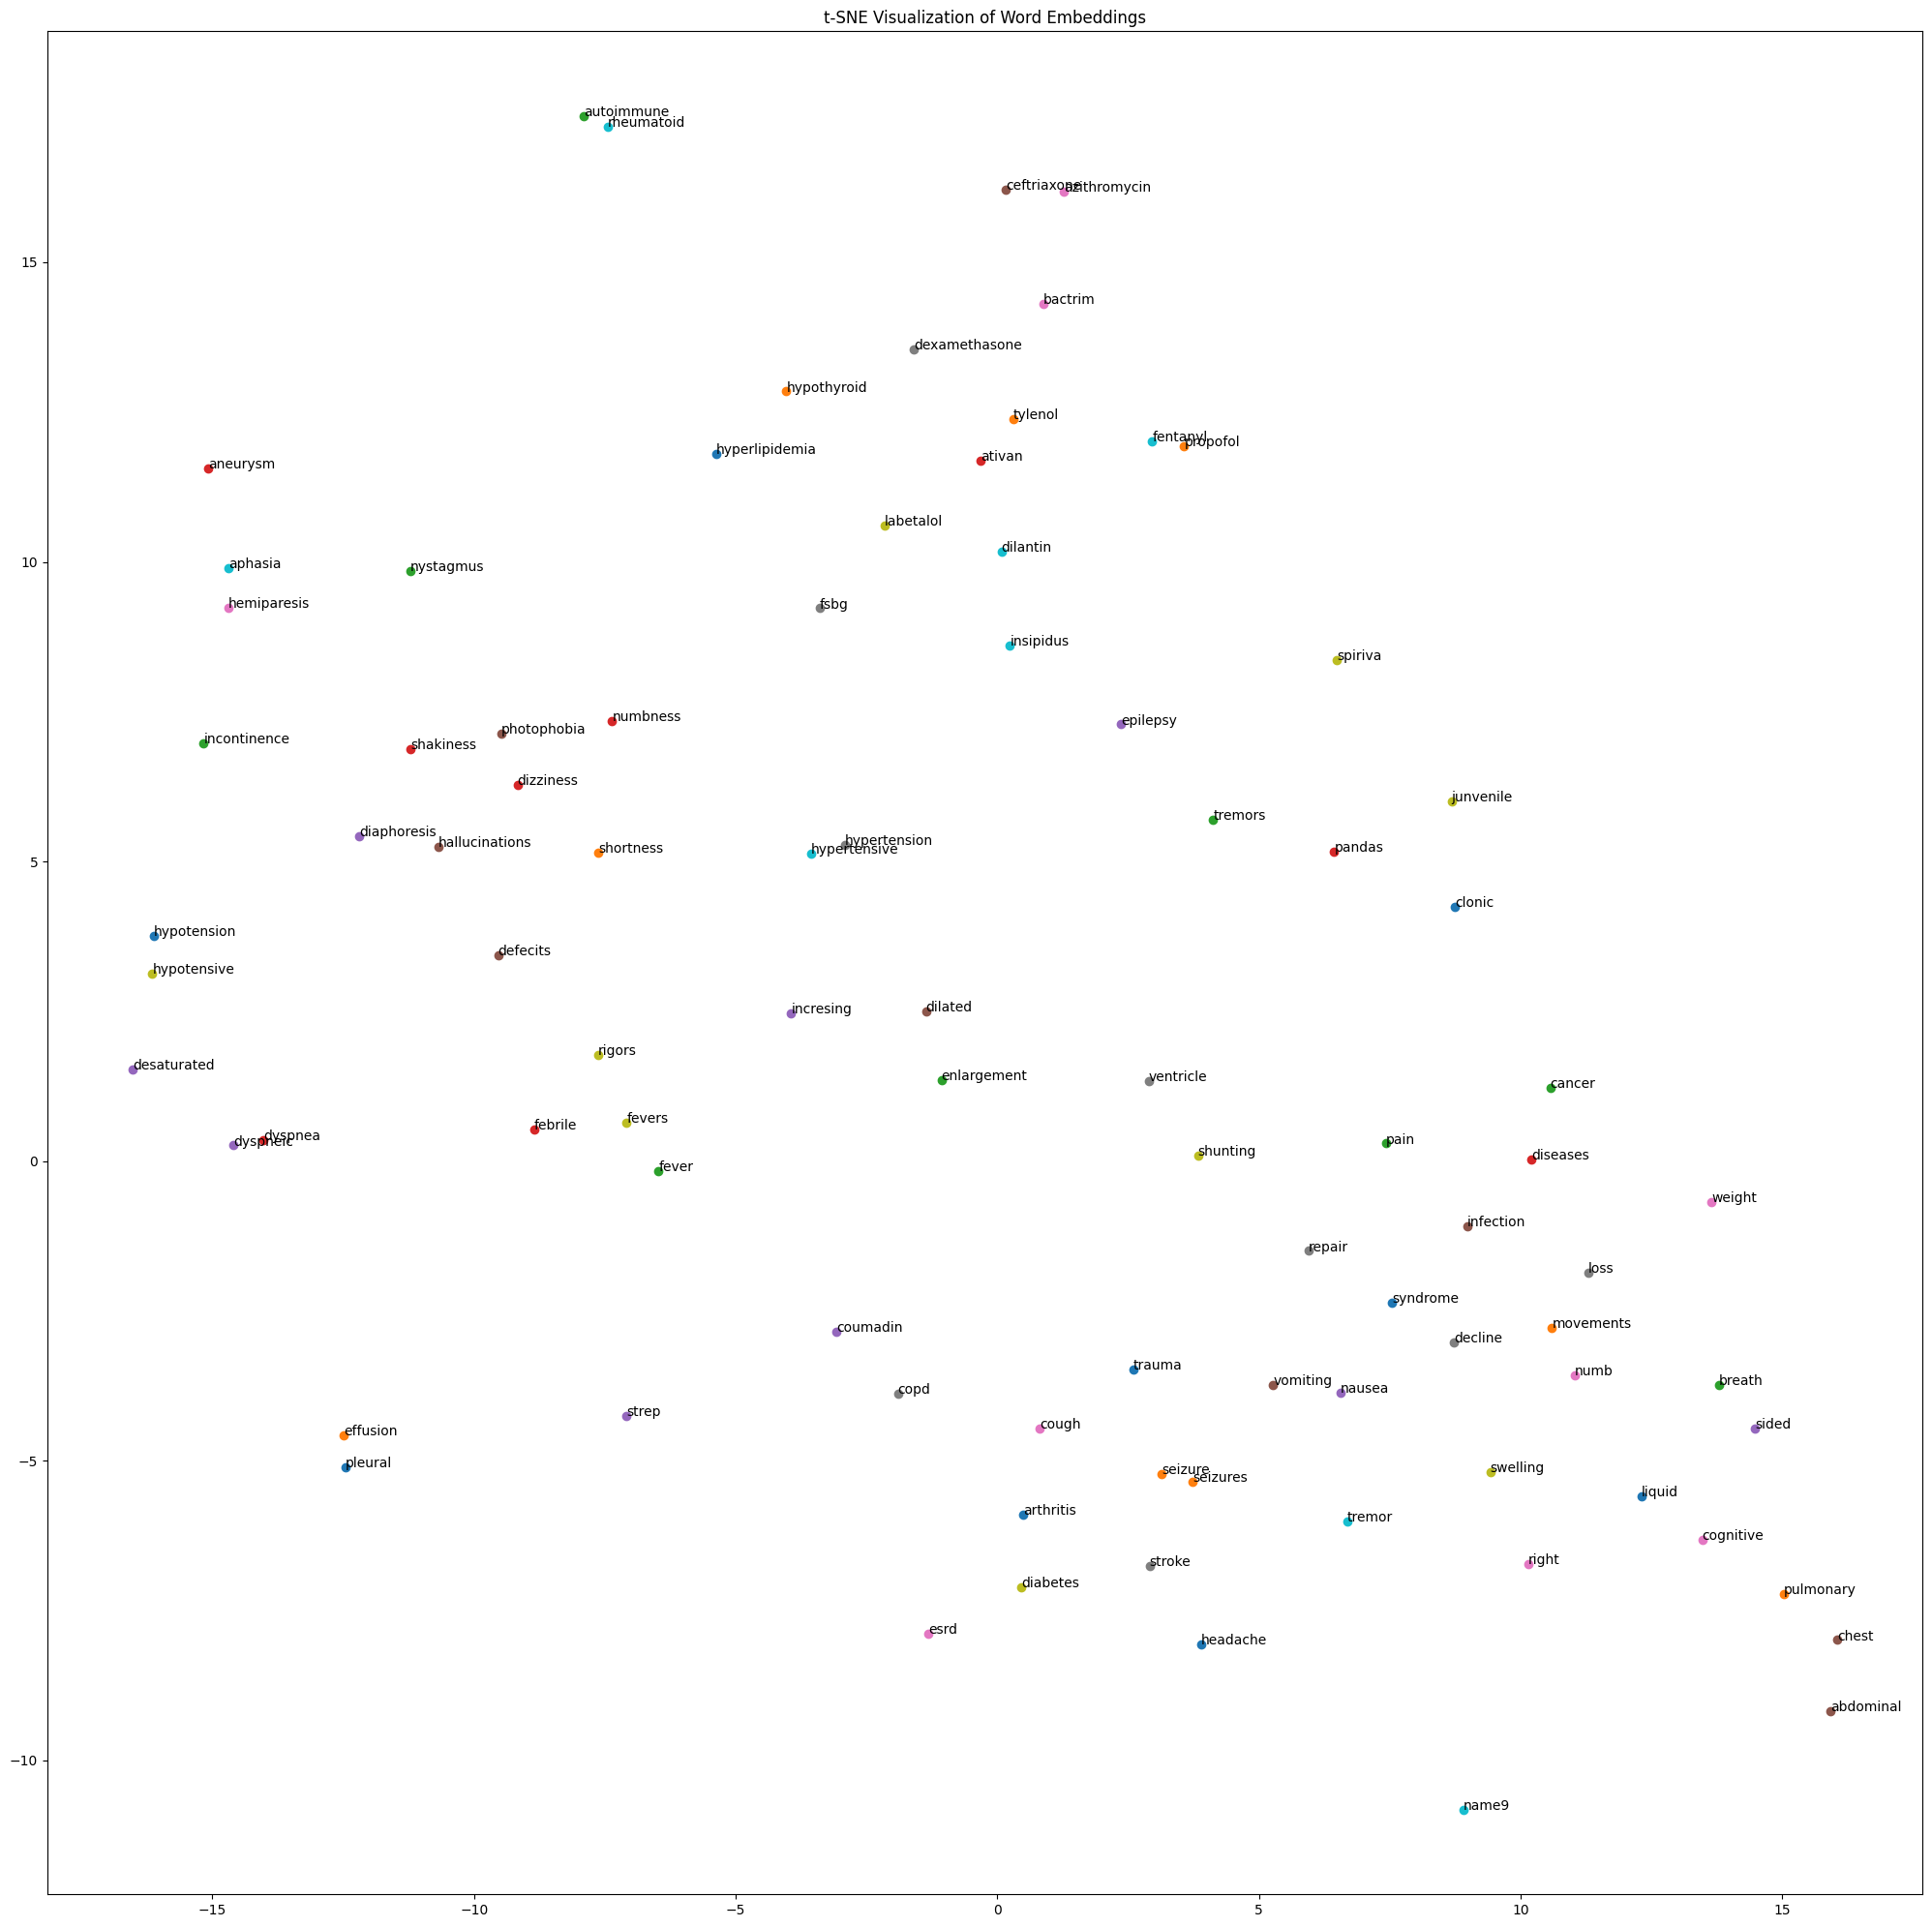

In [34]:
# Visualization of SciSpacy filtered notes using BlueBert


# Load the BERT model
blue_bert_model.eval()


# Example input text
input_text = clean_text(notes_combined)

# Tokenize the input text using the BERT tokenizer
# input_tokens = blue_tokenizer.tokenize(input_text)
input_tokens = input_text.split()

# Initialize an empty list to store word embeddings
word_embs = []

for token in input_tokens:
    # Check if the token is a valid word
    if token not in string.punctuation:
        # Encode the token using the BERT model
        inputs = blue_tokenizer(token, return_tensors="pt")
        with torch.no_grad():
            outputs = blue_bert_model(**inputs)
        token_emb = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        word_embs.append(token_emb)

# Perform t-SNE dimensionality reduction
tsne_model = TSNE(n_components=2, perplexity=10, random_state=42)
word_embs_2d = tsne_model.fit_transform(np.array(word_embs))

# Create a scatter plot of the word embeddings in 2D space
plt.figure(figsize=(25, 25))
for i in range(len(word_embs_2d)):
    plt.scatter(word_embs_2d[i, 0], word_embs_2d[i, 1])
    plt.annotate(input_tokens[i], (word_embs_2d[i, 0], word_embs_2d[i, 1]))

plt.title("t-SNE Visualization of Word Embeddings")
plt.show()


**SciBert**

In [35]:

for i in range(len(notes)):
  text = notes[i]
  word = words[i]
  # text = clean_text(text)
  scibert_model.eval()
  # Get the embedding for the sentence, as well as an embedding for word
  (sen_emb, word_emb) = get_embedding(scibert_model, scibert_tokenizer, text, word)
  print('Embedding sizes:')
  print(sen_emb.shape)
  print(word_emb.shape)
  print(sen_emb)
  print(f'word embedding for {word}')
  print(word_emb)

50 year old female presents after having fallen in the bathtub 4 days ago and hitting the back of her head. Since then she has had a massive [MASK]" which did not resolve with Tylenol. She states that she has a high threshold for pain and did not realize how bad it was during the day while at work but then when she got home at night she noticed it. The patient noticed ""silvery spects"" in her vision and she had trouble with some simple tasks like finding the tags on the back of her clothing in the morning. She reported that she had to check several times to make sure she did not put her clothes on backwards. She has had some dizziness, but no nausea or vomiting. Her speech has not been affected.
[102, 1539, 996, 4289, 3672, 4400, 647, 2773, 25811, 121, 111, 10648, 8263, 286, 1976, 10430, 137, 9663, 586, 111, 1542, 131, 1750, 2795, 205, 25916, 1067, 30107, 666, 2281, 434, 883, 106, 10133, 104, 1554, 334, 1544, 302, 11995, 190, 21291, 5063, 2682, 30115, 205, 25916, 108, 1898, 198, 2281,

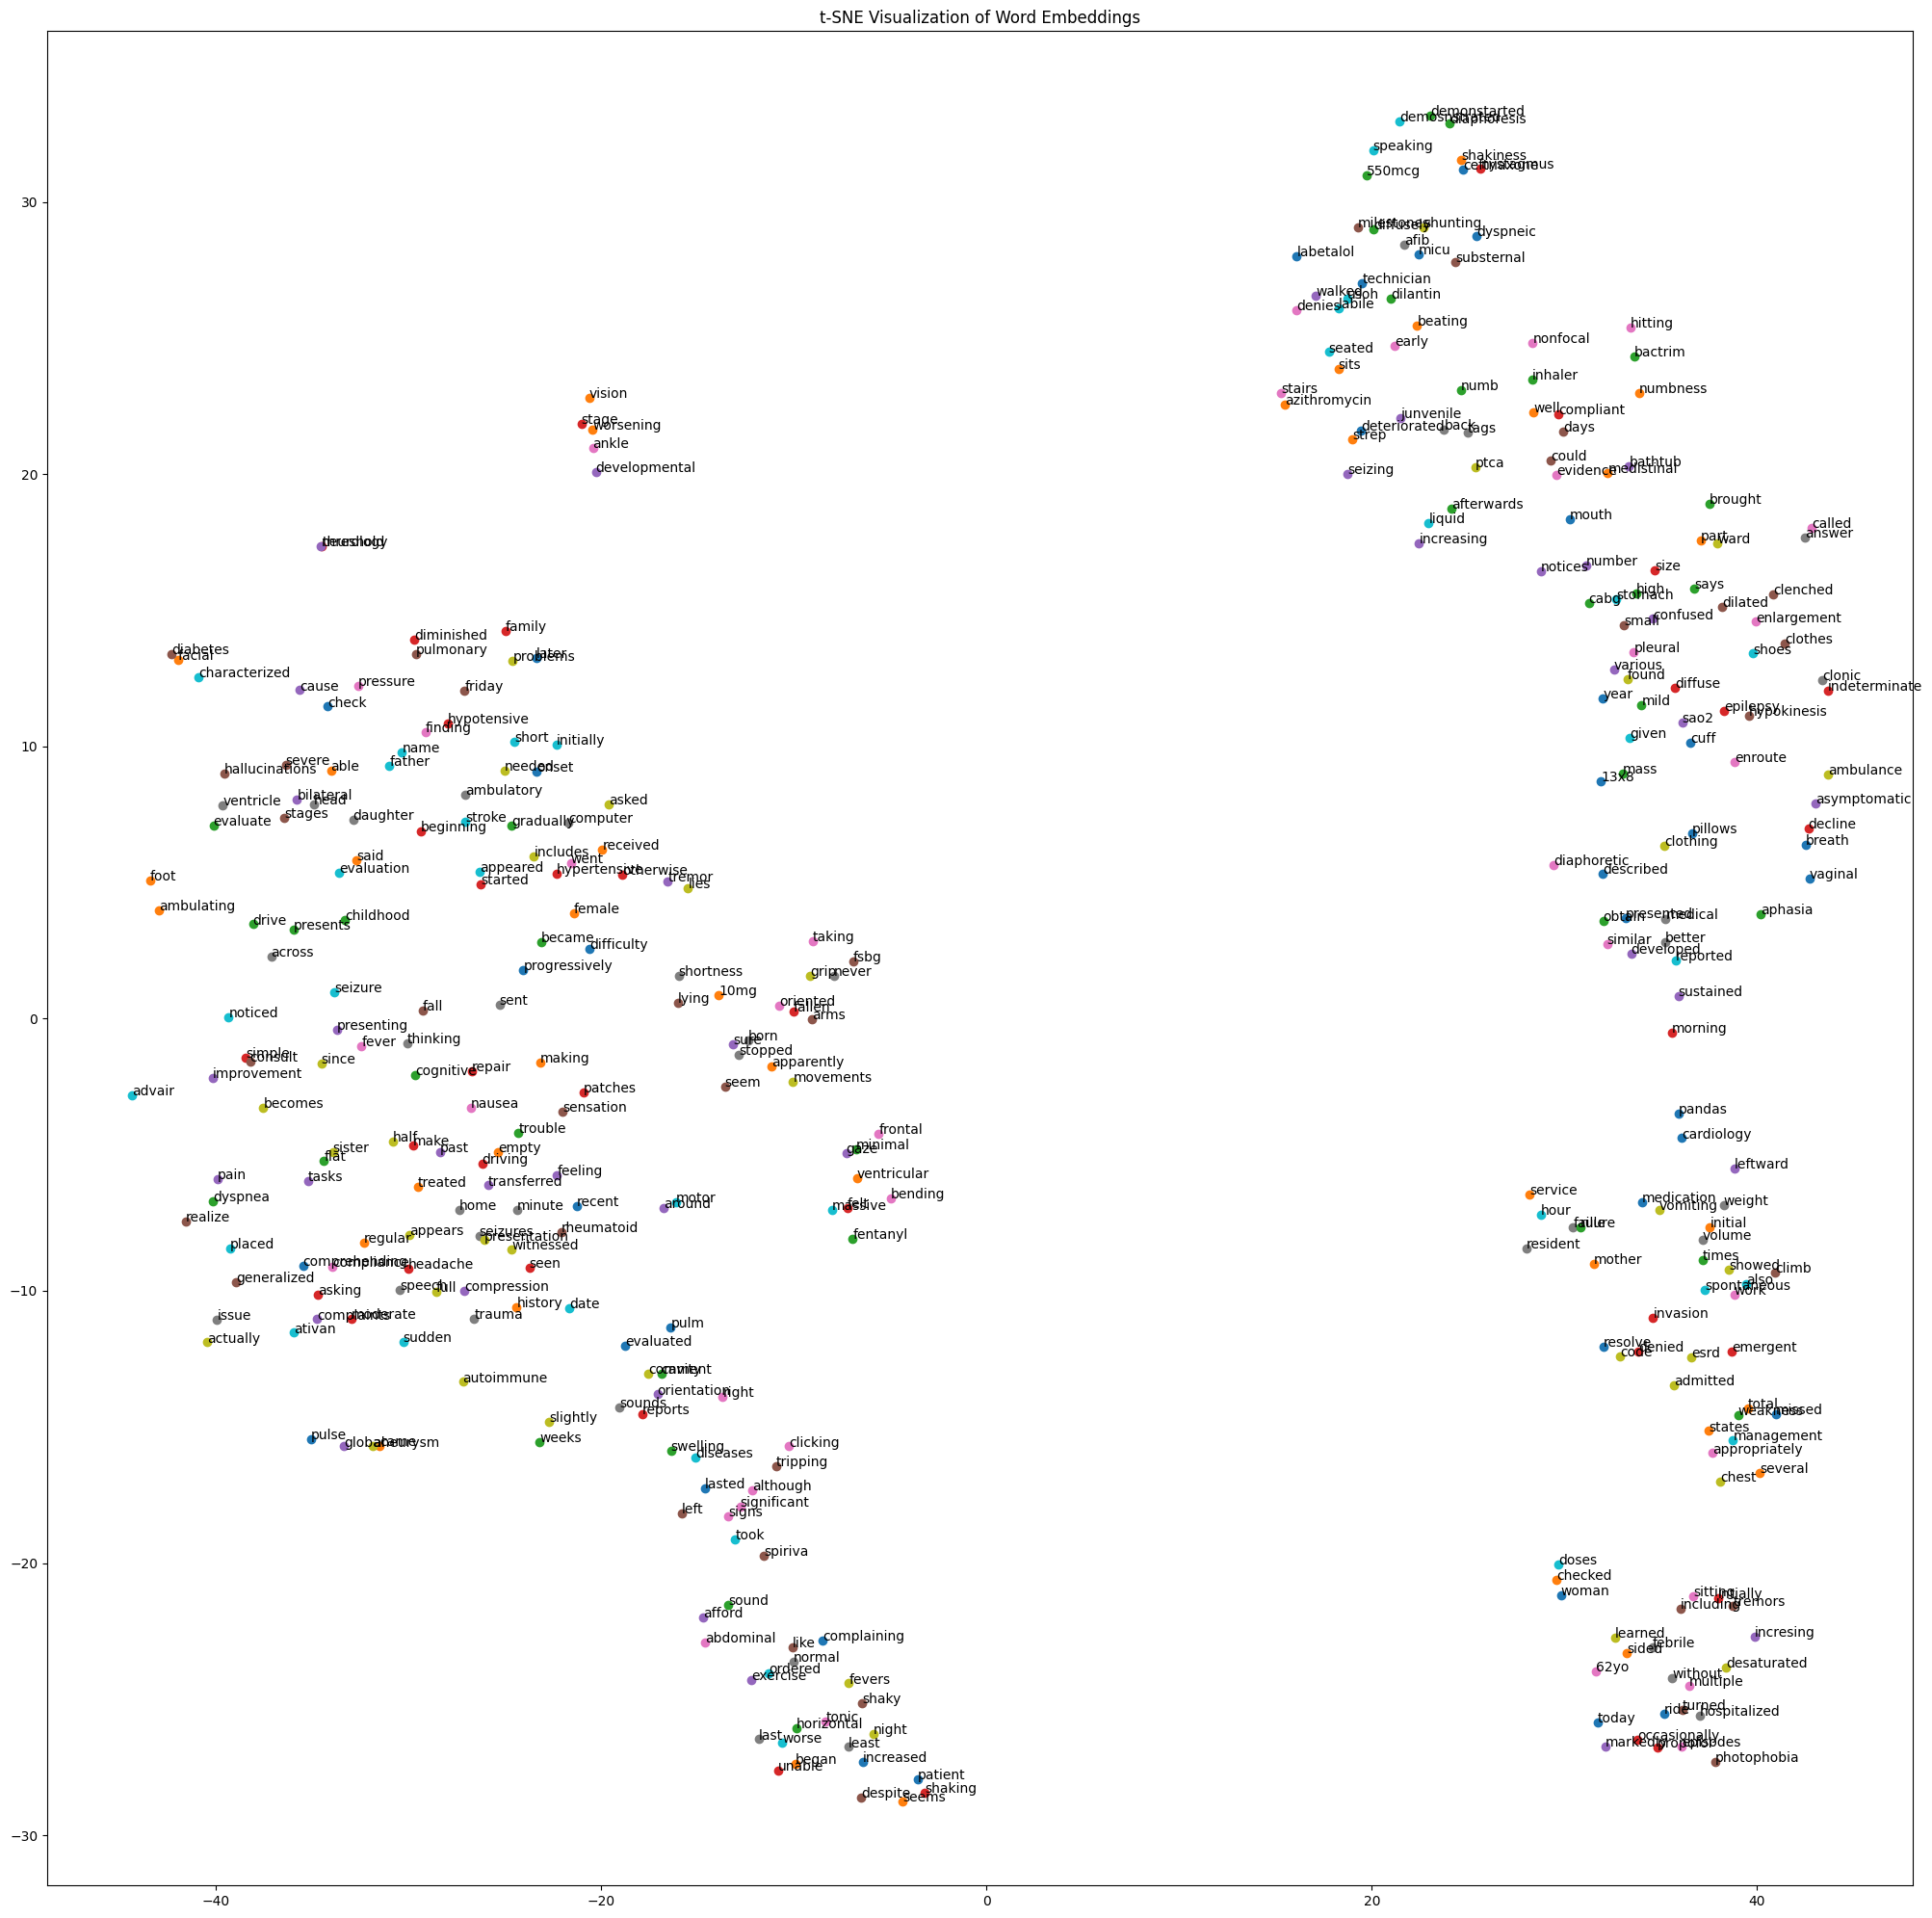

In [36]:
# Visualization of all notes using Scibert


# Load the BERT model
scibert_model.eval()

# Example input text
input_text = clean_text(all_notes_combined)

# Tokenize the input text using the BERT tokenizer
#input_tokens = scibert_tokenizer.tokenize(input_text)
input_tokens = input_text.split()
# Initialize an empty list to store word embeddings
word_embs = []

for token in input_tokens:
    # Check if the token is a valid word
    if token not in string.punctuation:
        # Encode the token using the BERT model
        inputs = scibert_tokenizer(token, return_tensors="pt")
        with torch.no_grad():
            outputs = blue_bert_model(**inputs)
        token_emb = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        word_embs.append(token_emb)

# Perform t-SNE dimensionality reduction
tsne_model = TSNE(n_components=2, perplexity=10, random_state=42)
word_embs_2d = tsne_model.fit_transform(np.array(word_embs))

# Create a scatter plot of the word embeddings in 2D space
plt.figure(figsize=(25, 25))
for i in range(len(word_embs_2d)):
    plt.scatter(word_embs_2d[i, 0], word_embs_2d[i, 1])
    plt.annotate(input_tokens[i], (word_embs_2d[i, 0], word_embs_2d[i, 1]))

plt.title("t-SNE Visualization of Word Embeddings")
plt.show()


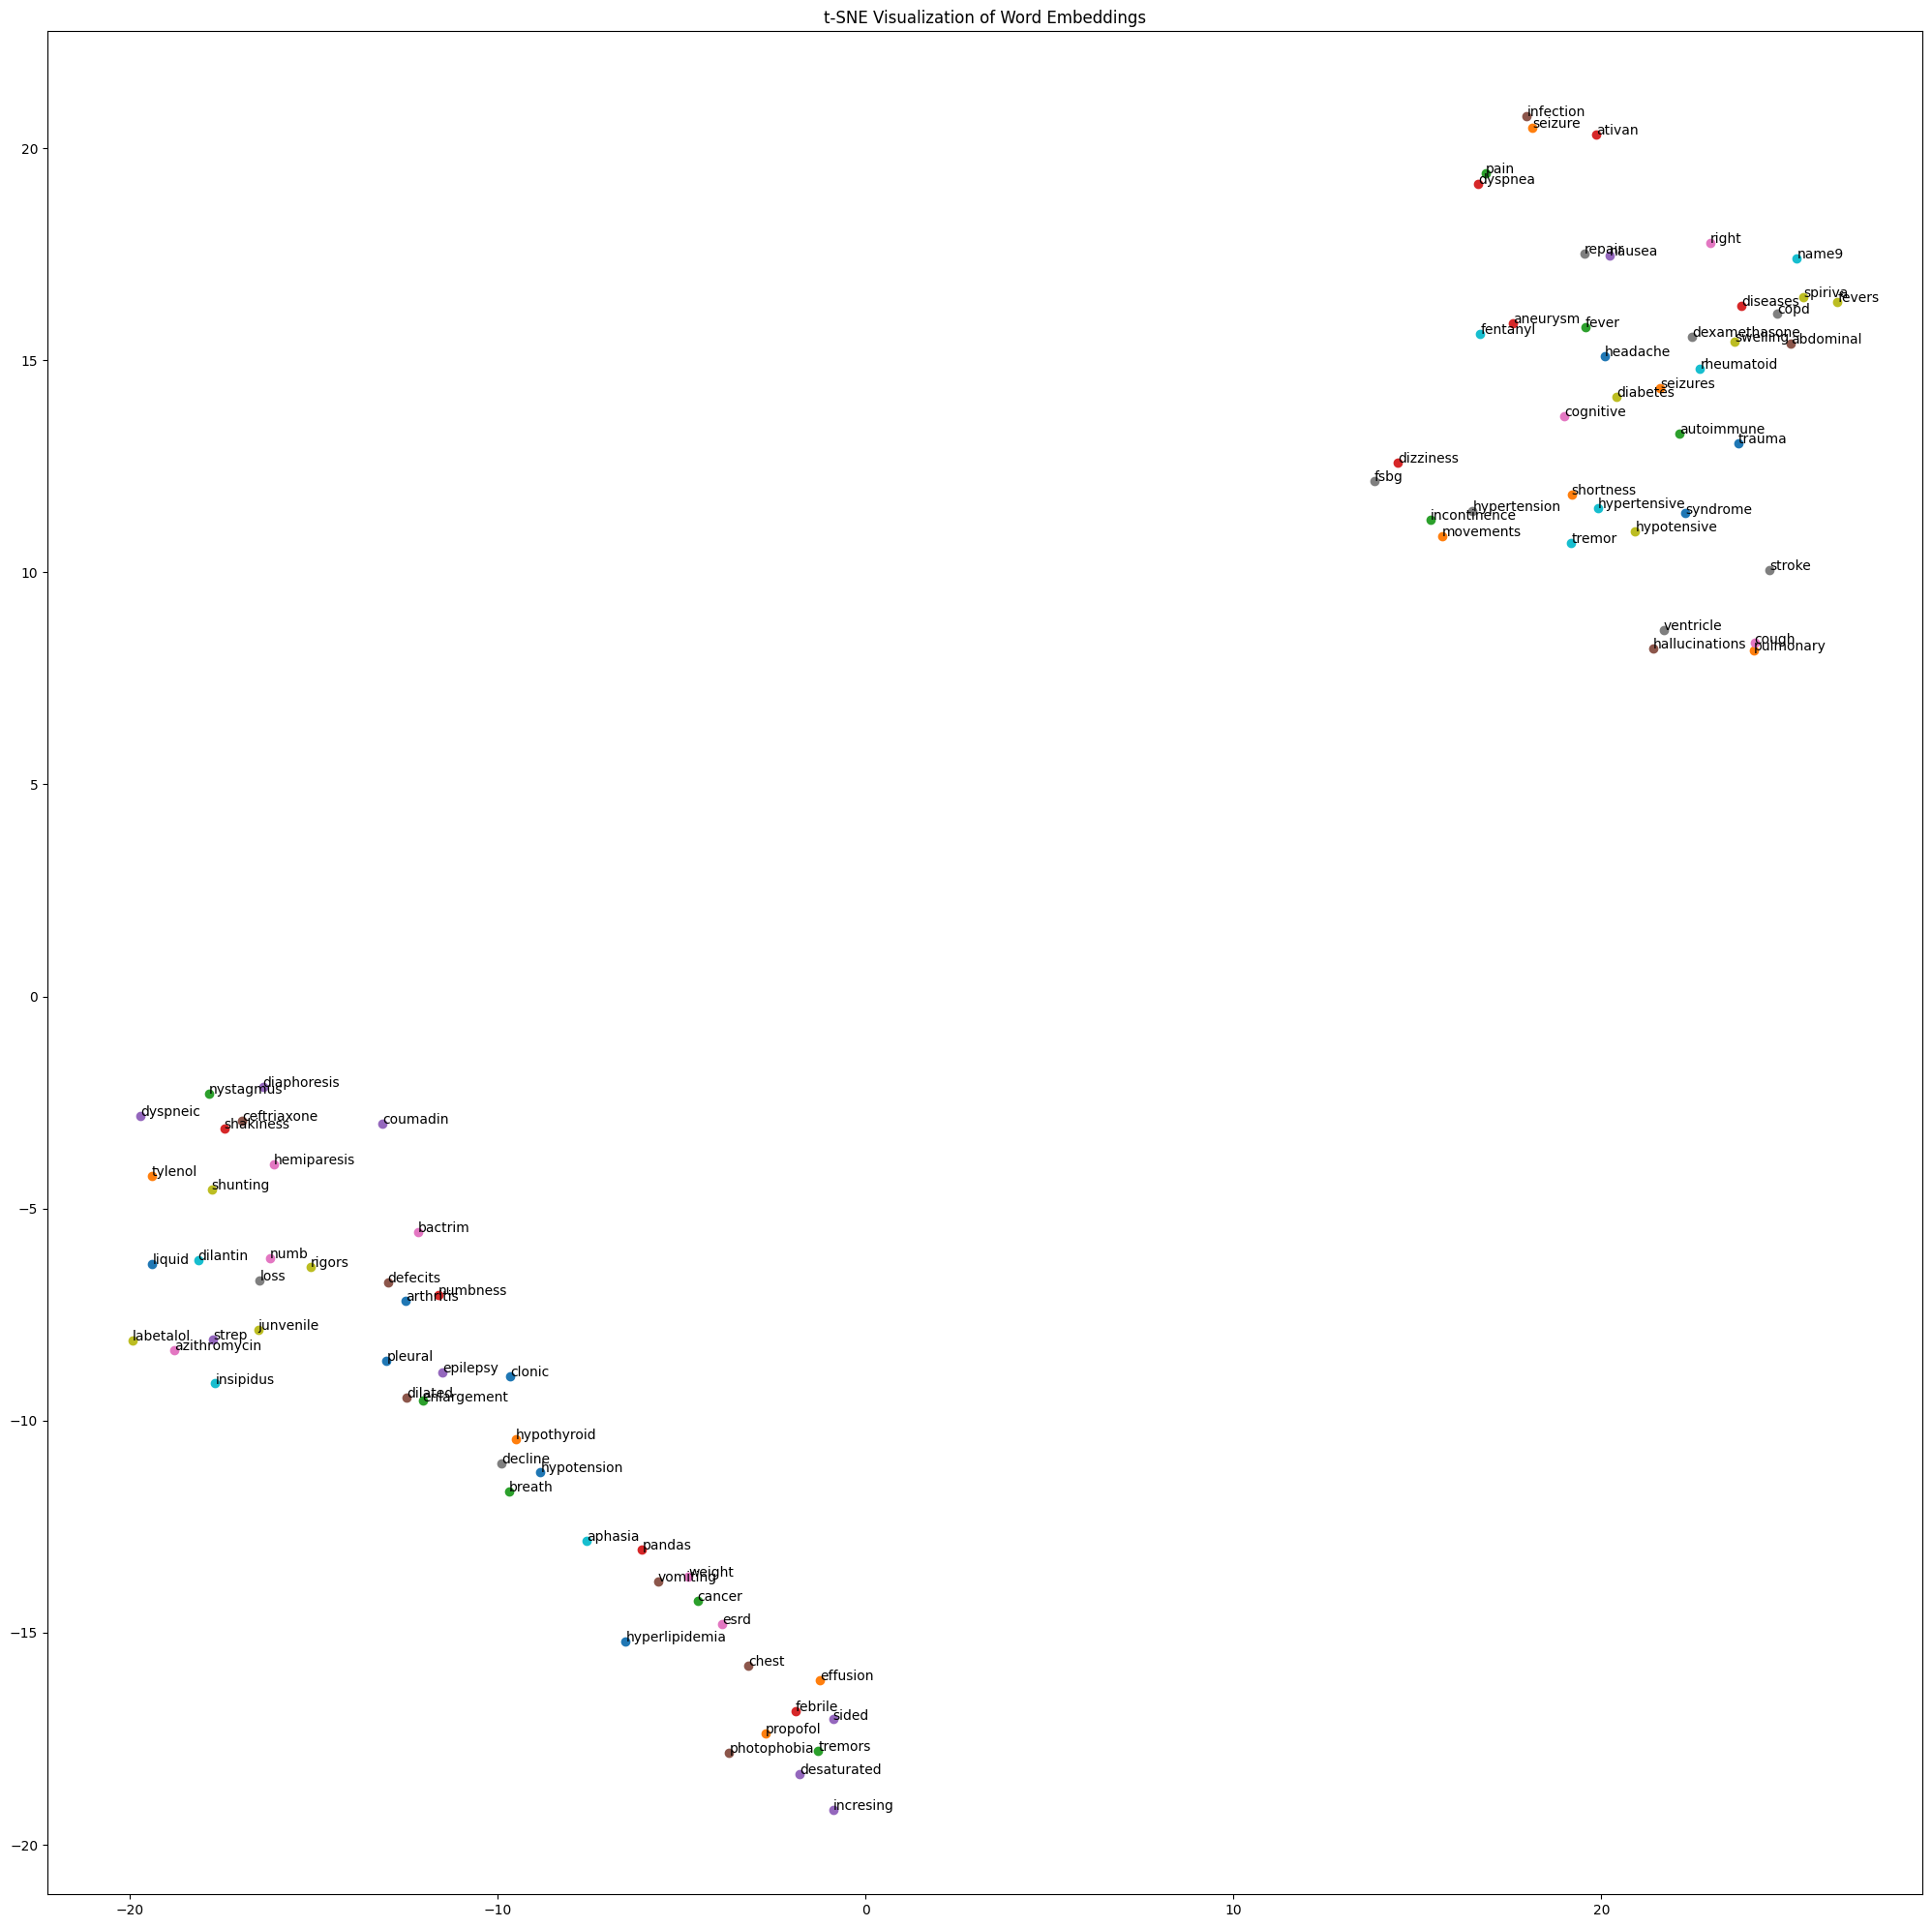

In [37]:
# Visualization of SciSpacy filtered notes using SciBert


# Load the BERT model
scibert_model.eval()

# Example input text
input_text = clean_text(notes_combined)

# Tokenize the input text using the BERT tokenizer
#input_tokens = scibert_tokenizer.tokenize(input_text)
input_tokens = input_text.split()

# Initialize an empty list to store word embeddings
word_embs = []

for token in input_tokens:
    # Check if the token is a valid word
    if token not in string.punctuation:
        # Encode the token using the BERT model
        inputs = scibert_tokenizer(token, return_tensors="pt")
        with torch.no_grad():
            outputs = blue_bert_model(**inputs)
        token_emb = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        word_embs.append(token_emb)

# Perform t-SNE dimensionality reduction
tsne_model = TSNE(n_components=2, perplexity=10, random_state=42)
word_embs_2d = tsne_model.fit_transform(np.array(word_embs))

# Create a scatter plot of the word embeddings in 2D space
plt.figure(figsize=(25, 25))
for i in range(len(word_embs_2d)):
    plt.scatter(word_embs_2d[i, 0], word_embs_2d[i, 1])
    plt.annotate(input_tokens[i], (word_embs_2d[i, 0], word_embs_2d[i, 1]))

plt.title("t-SNE Visualization of Word Embeddings")
plt.show()


# Appendix: ClinicalBERT, BioBERT vs. SciBERT



**Publish Dates & Authors**

* *BioBERT*
    * First submitted to arXiv: `Jan 25th, 2019`
        * [link](https://arxiv.org/abs/1901.08746)
    * First Author: Jinhyuk Lee
    * Organization: Korea University, Clova AI (also Korean)

* *SciBERT*
   * First submitted to arXiv: `Mar 26, 2019`
       * [arXiv](https://arxiv.org/abs/1903.10676), [pdf](https://arxiv.org/pdf/1903.10676.pdf)
    * First Author: Iz Beltagy
    * Organization: Allen AI


* *ClinicalBERT*
   * First submitted to arXiv: `Apr 10, 2019`
       * [arXiv](https://arxiv.org/abs/1904.05342), [pdf](https://arxiv.org/abs/1904.05342.pdf)
    * First Author: Kexin Huang
    * Organization: Harvard, Princeton, New York University


**huggingface transformers**

* Allen AI published their SciBERT models for the transformers library, and you can see their popularity:
    * [SciBERT uncased](https://huggingface.co/allenai/scibert_scivocab_uncased): ~16.7K downloads (from 5/22/20 - 6/22/20)
        * `allenai/scibert_scivocab_uncased`
    * [SciBERT cased](https://huggingface.co/allenai/scibert_scivocab_cased ): ~3.8k downloads (from 5/22/20 - 6/22/20)
        * `allenai/scibert_scivocab_cased`
* The BioBERT team has published their models, but not for the `transformers` library, as far as I can tell.
    * The most popular BioBERT model in the huggingface community appears to be [this one](https://huggingface.co/monologg/biobert_v1.1_pubmed): `monologg/biobert_v1.1_pubmed`, with ~8.6K downloads (from 5/22/20 - 6/22/20)
       * You could also download BioBERT's pre-trained weights yourself from https://github.com/naver/biobert-pretrained, but I'm not sure what it would take to pull these into the `transformers` library exactly.

* The original ClinicalBERT is not available in the huggingface. However, a better version of it (Bio-ClinicalBERT [model link](https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT) and [paper](https://arxiv.org/pdf/1904.03323.pdf))is available, which is used in this tutorial 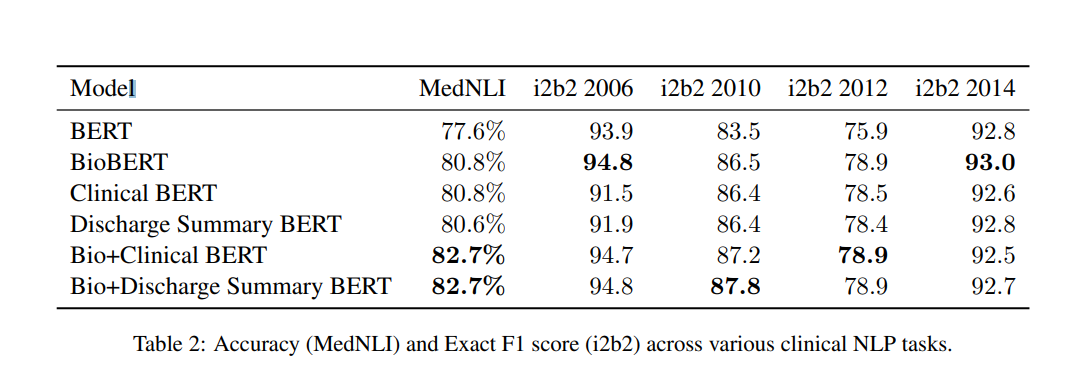